# BMME 890 - Final Project Presentation
Group Members: Joey Richardson, Keita Yokoyama, Keerthi Anand, Katie Heath

## Background

### Predicting tissue mechanical properties with Ultrasound VisR technique using Machine Learning

#### Elastography
A method of quantifying the mechanical properties of tissue using ultrasound. We use a VISR, or viscoelatic response Imaging to accomplish this. VISR uses a method of ultrasound imaging called ARFI.

ARFI, or acoustic radiation force imaging, pushes on tissue with strong ultrasound waves. These waves displace the tissue, allowing us to track how the tissue moves over time. 
<div><img src="presentation_images/visrML1/fig01-whatIsARFI.gif" style=width:"600" /></div>
![](images/capture.JPG)

VISR uses two ARFI pulses,  to displace tissue at a single location.  Using these displacement curves, we can calculate the the relative elasticity and viscosity in tissue.
<div><img src="presentation_images\visrML1\fig02-whatIsVisR.gif" style="width:800px"></div>

#### Quantitative vs Qualitative
Because the many different layers of tissue the waves must pass through to reach the target organ vary in their sound propogating properties, we cannot directly calculate the value of elasticity and viscosity. 
<div><img src="presentation_images\visrML1\new_normalVISR.png" style="width:600px"></div>

We want to use machine learning to find the absolute value of Young's modulus and viscous modulus.
<div><img src="presentation_images\visrML1\new_quantVISR.png" style="width:600px"></div>


# Imports

In [1]:
%matplotlib inline

# Standard Imports
import sys, os, json, copy, time
import statistics as stat

# Third Party Libraries
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Jupyter notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils, models

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Set Device for pytorch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
run_live=False

# Helper Function Definitions

In [2]:
# Create custom colormap based on terrain where the colors diverge between the blue (0.17) and green (0.25) values of the terrain colormap
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = mpl.colors.LinearSegmentedColormap.from_list('terrain_map', all_colors)

def show_arfidata(arfidata):
    if type(arfidata) == torch.Tensor:
        arfidata = arfidata.numpy()
        if np.max(arfidata) == 1:
            vcenter = 0.5
        else:
            vcenter = 0
    else:
        vcenter = 0
    if len(arfidata.shape) > 2: 
        arfidata = arfidata.squeeze()
    
    # Find peak displacement and negative peak displacement of arfidata
    peak = np.max(arfidata)
    negpeak = np.min(arfidata)
    
    # Setup diverging norm to scale colors based on the peak displacement and negative peak displacement
    vmin = negpeak if negpeak < 0 else -1
    divnorm = mpl.colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=peak)
    plt.imshow(arfidata, aspect='auto', norm=divnorm, cmap=terrain_map) 
    
    return (peak, negpeak)

def get_arfidata(sample):
    sample = sample.to_dict('report')[0]
    
    # Load Data
    file = os.path.join('matfiles', sample['filename'])
    mat = loadmat(file)
    
    # Extract data arrays
    arfidata = mat['arfidata'] 
    axial = mat['axial']
    #t = np.arange(0, arfidata.shape[1]*(1e-4), 1e-4)
    t = np.linspace(0, 4.3, arfidata.shape[1])
    
    # Clean
    mindepth=5;
    maxdepth=40;
    idx1 = (np.abs(axial - mindepth)).argmin()
    idx2 = (np.abs(axial - maxdepth)).argmin()
    axial = axial[idx1:idx2];
    arfidata = arfidata[idx1:idx2,:]
        
    # Find index of peak displacement and negative peak displacement
    sample['pd_ind'] = np.unravel_index(arfidata.argmax(), arfidata.shape)
    sample['npd_ind'] = np.unravel_index(arfidata.argmin(), arfidata.shape)
    
    return arfidata, axial, t, sample

def get_arfidata2(filename):    
    # Load Data
    file = os.path.join('matfiles', filename)
    mat = loadmat(file)
    
    # Extract data arrays
    arfidata = mat['arfidata'] 
    axial = mat['axial']
    t = np.linspace(0, 4.3, arfidata.shape[1])
    
    # Clean
    mindepth=5;
    maxdepth=40;
    idx1 = (np.abs(axial - mindepth)).argmin()
    idx2 = (np.abs(axial - maxdepth)).argmin()
    axial = axial[idx1:idx2];
    arfidata = arfidata[idx1:idx2,:]
        
    # Find index of peak displacement and negative peak displacement
    pd_ind = np.unravel_index(arfidata.argmax(), arfidata.shape)
    npd_ind = np.unravel_index(arfidata.argmin(), arfidata.shape)
    return arfidata, axial, t, (pd_ind, npd_ind)

def get_arfidata_dwnsmp(sample,downsampax,downsampt):
    sample = sample.to_dict('report')[0]
    
    # Load Data
    file = os.path.join('matfiles', sample['filename'])
    mat = loadmat(file)
    
    # Extract data arrays
    temparfidata = mat['arfidata']
    arfidata=temparfidata[0::downsampax,0::downsampt]
    tempaxial = mat['axial']
    axial=tempaxial[0::downsampax]
    #t = np.arange(0, arfidata.shape[1]*(1e-4), 1e-4)
    tempt = np.linspace(0, 4.3, temparfidata.shape[1])
    t=tempt[0::downsampt]

    # Clean
    mindepth=5;
    maxdepth=40;
    idx1 = (np.abs(axial - mindepth)).argmin()
    idx2 = (np.abs(axial - maxdepth)).argmin()
    axial = axial[idx1:idx2];
    arfidata = arfidata[idx1:idx2,:]
        
    # Find index of peak displacement and negative peak displacement
    sample['pd_ind'] = np.unravel_index(arfidata.argmax(), arfidata.shape)
    sample['npd_ind'] = np.unravel_index(arfidata.argmin(), arfidata.shape)
    
    return arfidata, axial, t, sample

def visualize_arfidata_sample(sample, depth):
    arfidata, axial, t, sample = get_arfidata(sample)
     
    # Extract peak displacement curves through time and depth
    pd_time = arfidata[sample['pd_ind'][0], :]
    pd_depth = arfidata[:, sample['pd_ind'][1]]
    
    print('Peak Displacement of ' + str(np.round_(arfidata[sample['pd_ind'][0], sample['pd_ind'][1]],2)) + ' um occured at '
         + str(np.round_(t[sample['pd_ind'][1]])) + ' s at depth of '  + str(np.round_(axial.flatten()[sample['pd_ind'][0]])) + ' mm')
    
    idx_depth = (np.abs(axial - depth)).argmin()
    d_depth = arfidata[idx_depth, :]   
    # Plot
    plt.subplot(131)
    plt.plot(t, pd_time)
    plt.xlabel('Time (ms)')
    plt.ylabel('Displacement (um)')
    plt.axis([t.min(), t.max(), pd_time.min(), pd_time.max()])
    plt.title('Disp vs Time at Peak Disp')
    
    plt.subplot(132)
    plt.plot(t, d_depth)
    plt.xlabel('Depth (mm)')
    plt.ylabel('Displacement (um)')
    plt.axis([t.min(), t.max(), pd_time.min(), pd_time.max()])
    plt.title('Disp vs Time at Depth of ' + str(np.round_(depth,2)) + 'mm')
    
    plt.subplot(133)
    plt.imshow(arfidata, aspect='auto', vmin=-1*arfidata[sample['pd_ind']], vmax=arfidata[sample['pd_ind']], cmap=plt.cm.RdBu)
    plt.xlabel('Time (ms)')
    plt.ylabel('Depth (mm)')
    plt.title('Disp over Depth and Time')
    plt.colorbar()
    
    plt.suptitle('Displacement across time and depth for Elasticity {} and Viscosity {}'.format(sample['elasticity'], sample['viscosity']) )
    plt.subplots_adjust(left=None, bottom=None, right=3, top=None, wspace=.2, hspace=None)
    
    plt.show()
    

# Data Visualization

## Open metadata.json and display

In [3]:
with open('metadata.json') as json_file:
    metadata = pd.DataFrame(json.load(json_file))
    metadata = metadata.apply(pd.to_numeric, errors='ignore')

focal_depths = list(np.sort(metadata['focal_depth'].unique()))
elasticities = list(np.sort(metadata['elasticity'].unique()))
viscosities = list(np.sort(metadata['viscosity'].unique()))
seeds = list(np.sort(metadata['seed'].unique()))

print(metadata.head())
print()
print('Total number of samples: ', len(metadata))

   refID                  filename  focal_depth  elasticity  viscosity  seed
0      0  data_15_100_0.01_0_0.mat           15       100.0       0.01     0
1      1  data_15_100_0.01_1_1.mat           15       100.0       0.01     1
2      2  data_15_100_0.01_2_2.mat           15       100.0       0.01     2
3      3  data_15_100_0.01_3_3.mat           15       100.0       0.01     3
4      4  data_15_100_0.01_4_4.mat           15       100.0       0.01     4

Total number of samples:  23047


## Metadata Sampling

In [4]:
# Only keep focal depths where there are 1000 samples (10 elasticities x 10 viscosities x 10 seeds)
metadata_fullsets = metadata.groupby(['focal_depth']).filter(lambda df: df['refID'].count() == 1000)

# Keep one seed for each focal depth, elasticity, viscosity combination
metadata_singleseed = metadata.groupby(['focal_depth', 'elasticity', 'viscosity']).apply(lambda df: df.sample(n=1)).reset_index(drop=True)

print('Fullsets total samples: ', metadata_fullsets['filename'].count())
print('Single seed total samples: ', metadata_singleseed['filename'].count())

Fullsets total samples:  12000
Single seed total samples:  2309


## Interactive Visualize Displacement Profiles

In [5]:
@interact
def visualize_arfidata_samples(fd=focal_depths, e=elasticities, v=viscosities, s=seeds, d=np.linspace(5,40,71)):
    sample = metadata.query('focal_depth == {} & elasticity == {} & viscosity == {} & seed == {}'.format(fd,e,v,s))
    return visualize_arfidata_sample(sample,d)
    
sample = metadata.query('focal_depth == {} & elasticity == {} & viscosity == {} & seed == {}'.format(15,100,0.01,1))

interactive(children=(Dropdown(description='fd', options=(15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, …

## Interactive Visualize Displacement Images

In [7]:
#Look at effects of elasticity and viscosity at each focal depth
e = elasticities
v = viscosities

PD = np.zeros((len(e), len(v)))
NPD = np.zeros((len(e), len(v)))

# Generate interactive plot with dropdown variables fd and s
@interact
def visualize_2d_displacements(fd=focal_depths, s=seeds):
    subplot_kw = {'xticklabels': [], 'yticklabels': []}
    fig, axes = plt.subplots(len(e), len(v), subplot_kw=subplot_kw)

    for i, axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            sample = metadata.query('focal_depth == {} & elasticity == {} & viscosity == {} & seed == {}'.format(fd,e[i],v[j],s))
            arfidata, axial, t, sample = get_arfidata(sample)
            PD[i,j] = arfidata[sample['pd_ind']]
            NPD[i,j] = arfidata[sample['npd_ind']]
            
            # Setup diverging norm to scale colors based on the max PD of a row (fixed elasticity) and centered at 0
            vmin = NPD[i,0] if NPD[i,0] < 0 else -1
            divnorm = mpl.colors.DivergingNorm(vmin=vmin, vcenter=0, vmax=PD[i,0])
            ax.imshow(arfidata, aspect='auto', norm=divnorm, cmap=terrain_map)    
                
            if i == len(axes) - 1:
                ax.set_xlabel(v[j])
            if j == 0:
                ax.set_ylabel(e[i], rotation=0, labelpad=20)
            if j == len(axes) - 1:
                ax.yaxis.set_label_position('right')
                ax.set_ylabel('{}\n{}'.format( round(PD[i,0],2), round(NPD[i,0],2)), rotation=0, labelpad=25)
            if i == 0 and j == 0:
                ax.set_title('2d Displacement Images for FD: {} and Seed: {}'.format(fd, s))
                

    fig.text(3.75/2, 0.01, 'Viscosities', ha='center', va='center')
    fig.text(0.02, 1.6, 'Elasticities', ha='center', va='center', rotation='vertical')
    fig.text(3.9, 1.5, 'Max PD and NPD per Row', ha='center', va='center', rotation='vertical')
    plt.subplots_adjust(left=None, bottom=None, right=3.75, top=3, wspace=0, hspace=0)
    return plt.show()


interactive(children=(Dropdown(description='fd', options=(15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, …

## Interactive Visualize Displacement Images 3D

In [8]:
def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

fd=15
elas=5.0 #[5.0, 15.56, 26.11, 36.67, 47.22, 57.78, 68.33, 78.89, 89.44, 100.0]
vis=0.01 #[0.01, 0.79, 1.57, 2.34, 3.12, 3.9, 4.68, 5.45, 6.23, 7.01]
seed=0
downsampt=1
downsampax=100
e_summ = [5.0, 100.0]
v_summ = [0.01, 7.01]
downsampts=[1, 2, 4, 5, 10]
downsampaxs=[50 , 100, 200, 500]

@interact
def visualize_3d_displacements(fd=focal_depths, s=seeds, time_sf=downsampts, axial_sf=downsampaxs):
    fig = plt.figure(figsize=(15,15))
    
    for k in range(np.size(e_summ)):
        for l in range(np.size(v_summ)):
            sample = metadata.query('focal_depth == {} & elasticity == {} & viscosity == {} & seed == {}'.format(fd,e_summ[k],v_summ[l],s))
            arfidata, axial, t, sample = get_arfidata_dwnsmp(sample, axial_sf,time_sf)
            ind=(k)*np.size(v_summ)+(l+1)
            ax = fig.add_subplot(np.size(e_summ), np.size(e_summ), ind, projection='3d')
            dispshift=0
            verts2=[]
            for i in range(np.size(axial)):
                ys = arfidata[i,:].copy()
                ys[0]=dispshift
                ys[-1]=dispshift
                ys[np.argwhere(ys > .1)]=0
                templs=list(zip(t, ys))
                verts2.append(templs) 
            poly1 = PolyCollection(verts2, facecolors=[cc('r')])
            poly1.set_alpha(0.3)
            ax.add_collection3d(poly1, zs=axial.flatten(), zdir='y')
            sample = metadata.query('focal_depth == {} & elasticity == {} & viscosity == {} & seed == {}'.format(fd,e_summ[k],v_summ[l],s))
            arfidata, axial, t, sample = get_arfidata_dwnsmp(sample,axial_sf,time_sf)
            verts2=[]
            for i in range(np.size(axial)):
                ys2 = arfidata[i,:].copy()
                ys2[0]=dispshift
                ys2[-1]=dispshift
                ys2[np.argwhere(ys2 < .1)]=0
                templs2=list(zip(t, ys2))
                verts2.append(templs2) 
            poly2 = PolyCollection(verts2, facecolors=[cc('b')])
            poly2.set_alpha(0.3)
            ax.add_collection3d(poly1, zs=axial.flatten(), zdir='y')
            ax.add_collection3d(poly2, zs=axial.flatten(), zdir='y')
            ax.set_xlabel('Time')
            ax.set_xlim3d(0,4)
            ax.set_ylabel('Depth')
            ax.set_ylim3d(5, 40)
            ax.set_zlabel('Displacement')
            ax.set_zlim3d( np.min(arfidata),  np.max(arfidata))
            ax.set_title('Elasticity: ' + str(e_summ[k]) + ' Viscosity: ' + str(v_summ[k]))
            ax.view_init(45, 60)
    plt.show()     

interactive(children=(Dropdown(description='fd', options=(15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, …

## Median Dataset

### Evidence supporting median averaging

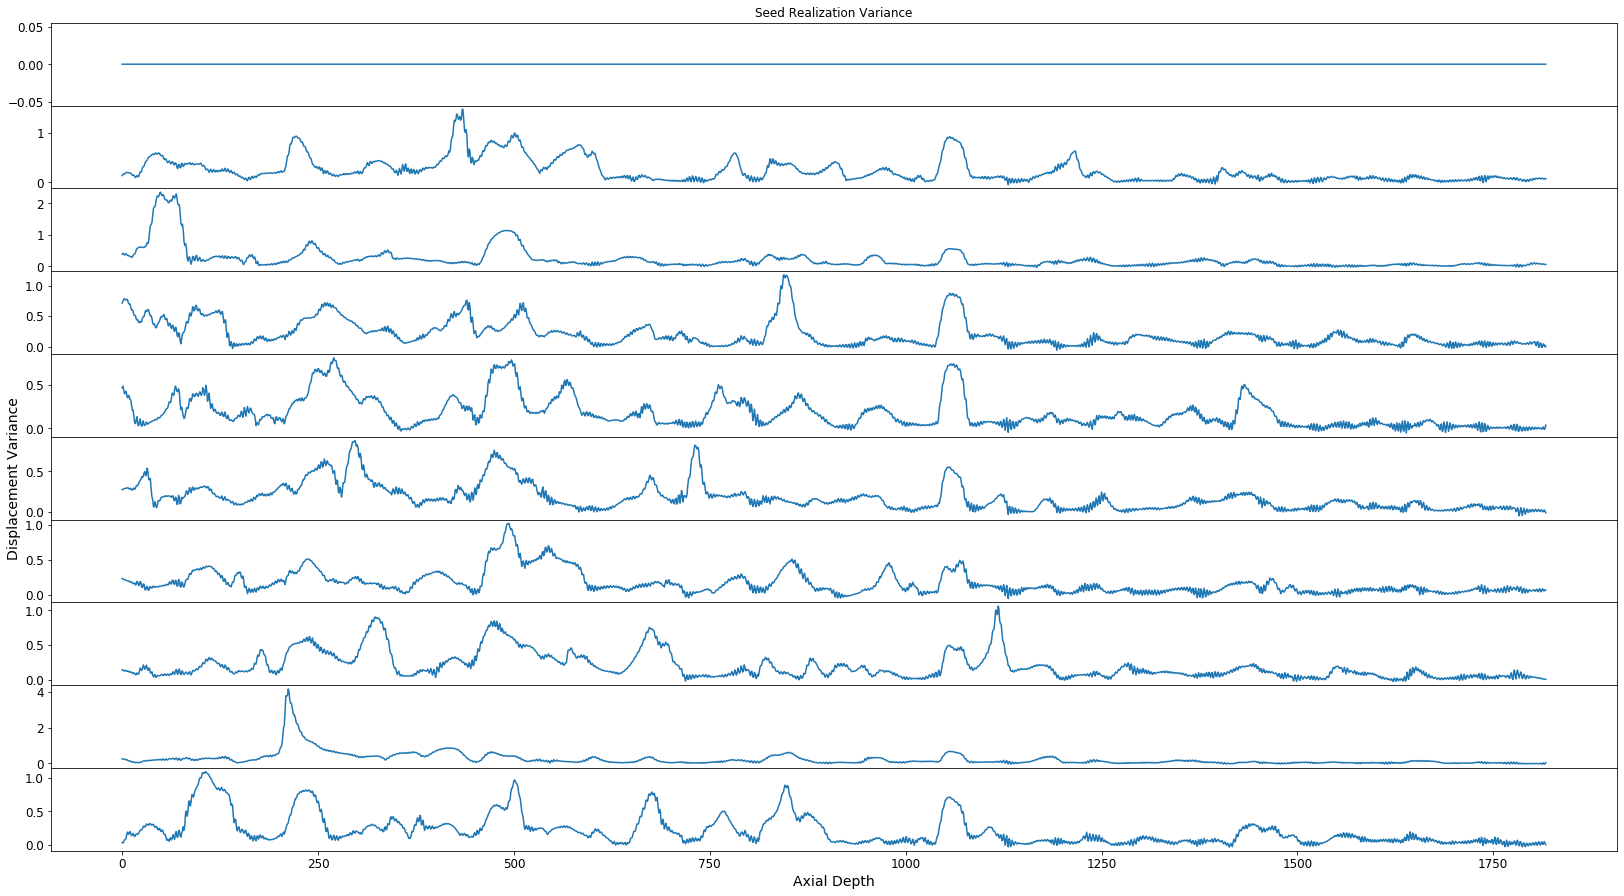

In [9]:
fig, axes = plt.subplots(10, 1)

sample = metadata.query('focal_depth == {} & elasticity == {} & viscosity == {} & seed == {}'.format(25,47.22,3.12, 0))
filename = sample['filename'].values[0]
arfidata, axial, t, (pd_ind, npd_ind) = get_arfidata2(filename)

for i, ax in enumerate(axes):
    sample2 = metadata.query('focal_depth == {} & elasticity == {} & viscosity == {} & seed == {}'.format(25,47.22,3.12, i))
    filename2 = sample2['filename'].values[0]
    arfidata2, axial2, t2, (pd_ind2, npd_ind2) = get_arfidata2(filename2)
    diff = arfidata - arfidata2
    dispmeandiff = np.max(diff, axis=1)
    ax.plot(dispmeandiff)
    if i == 0:
        ax.set_title('Seed Realization Variance')
    elif i == 5:
        ax.set_ylabel('Displacement Variance')
    ax.set_xlabel('Axial Depth')
    
plt.subplots_adjust(left=None, bottom=None, right=3.75, top=3, wspace=0, hspace=0)

### Generate Dataset

In [10]:
if run_live:
    # Generate median displacement images over the scatterer realizations and save
    metadata_allseedlist = metadata.groupby(['focal_depth', 'elasticity', 'viscosity']).apply(lambda group: group['filename'].tolist()).reset_index()
    for i, row in metadata_allseedlist.iterrows():
        outfilename = 'median_matfiles/data_{}_{}_{}.mat'.format(row['focal_depth'], row['elasticity'], row['viscosity'])  

        if not os.path.exists(outfilename):
            arfidatas = []
            axials = []
            for j, filename in enumerate(row[0]):
                try:
                    arfidata, axial = get_arfidata(filename)[0:2]
                except FileNotFoundError:
                    continue
                arfidatas.append(arfidata)
                axials = axial

            if len(arfidatas) > 3:
                median_arfidata = np.median(np.asarray(arfidatas), axis=0)
                savemat(outfilename, {'arfidata': median_arfidata, 'axial': axials})

            if i % 100 == 0: 
                print(i)

### Create Median Metadata

In [11]:
# Create median metadata
medfiles = os.listdir('median_matfiles')
fd, e, v = [], [], []
for idx, file in enumerate(medfiles):
    fileparts = str.split(file, '_')
    fd.append(fileparts[1])
    e.append(fileparts[2])
    v.append(fileparts[3][:-4])
    
fd, e, v = np.array(fd, dtype='float'), np.array(e, dtype='float'), np.array(v, dtype='float')

metadata_median = pd.DataFrame({'filename': medfiles, 'focal_depth': fd, 'elasticity': e, 'viscosity': v})
print(metadata_median.head())
print()
print('Total number of samples: ', len(metadata_median))

                 filename  focal_depth  elasticity  viscosity
0  data_15_100.0_0.01.mat         15.0       100.0       0.01
1  data_15_100.0_0.79.mat         15.0       100.0       0.79
2  data_15_100.0_1.57.mat         15.0       100.0       1.57
3  data_15_100.0_2.34.mat         15.0       100.0       2.34
4  data_15_100.0_3.12.mat         15.0       100.0       3.12

Total number of samples:  2206


## Load/Save Datasets

In [ ]:
from utils.datasets import generate_dataset_at_fd
from utils.datasets import generate_dataset_minmaxdepth

# Generate Datasets
if run_live:
    data = generate_dataset_minmaxdepth(metadata_median, 'median_matfiles', n=1000, mindepth=5, maxdepth=40)
    savemat('datasets/dataset_1000samples_minmax_median.mat', {'data': data})

In [ ]:
data = loadmat('datasets/dataset_10samples_minmax.mat')['data']

## Network Diagrams

<div><img src="presentation_images\visrML1\Flowchart_regressors.png" style="width:800px"></div>


<div><img src="presentation_images\visrML1\Flowchart_CNN.png" style="width:800px"></div>


# Dimensionality Reduction and Sklearn Regressors

## Preprocessing

In [48]:
if run_live:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()

    # Randomly Shuffle Data
    shuffdata=data
    np.take(shuffdata,np.random.permutation(data.shape[0]),axis=0,out=shuffdata)
    X = shuffdata[:,0:45]
    y = shuffdata[:,45:47]

    # Normalize displacements along each displacement profile
    disps = X[:,0:43]
    disps = scaler.fit_transform(disps.T).T
    X_scl= np.zeros(np.shape(X))
    X_scl[:,0:43] = disps

    # Normalize axial depth, focal depth along each column
    fds = X[:,43:45]
    fds_scl = scaler.fit_transform(fds)
    X_scl[:,43:45] = fds_scl[:,0:2]

## Train Regressor Models

In [49]:
# Use Grid Search CV to find the best hyperparameters for decision tree regressor
if run_live:
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV

    #Function to calculate rmse
    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

    #Split training and test sets for raw, unscaled data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    #Split training and test sets for scaled data 
    X_scl_train, X_scl_test, y_scl_train, y_scl_test = train_test_split(X_scl, y, test_size=0.33, random_state=42)

    

### Grid Search CV for Descision Tree (Unscaled Data)

In [ ]:
#Define grid of parameters
if run_live:
    param_grid = [
        {'max_depth': [2, 5, 10, 20, 40, 60, 80], 'max_features': [2, 4, 10, 20, 40, 45]},
      ]

    #Compute neg-mse for each parameter with raw, unscaled data 
    reg = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)
    grid_search.fit(X_train, y_train)

    print('Best parameters:')
    print(grid_search.best_estimator_)
    print('\n')
    print('All parameters:')
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

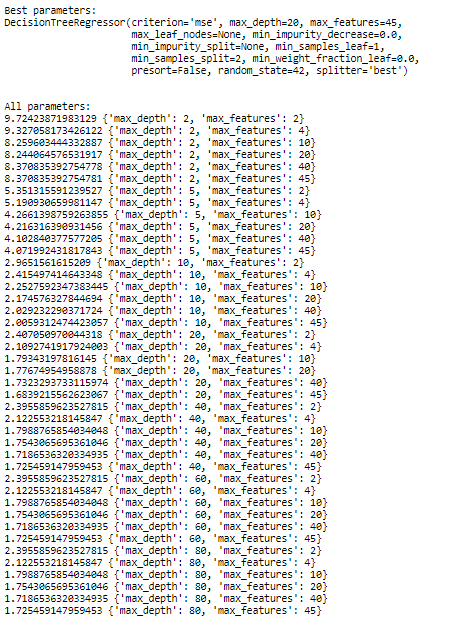

### Grid Search CV for Descision Tree (Scaled Data)

In [50]:
#Compute neg-mse for each parameter with scaled data
if run_live:
    reg = DecisionTreeRegressor(random_state=42)

    grid_search = GridSearchCV(reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)

    grid_search.fit(X_scl_train, y_scl_train)
    print('Best parameters:')
    print(grid_search.best_estimator_)
    print('\n')
    print('All parameters:')
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

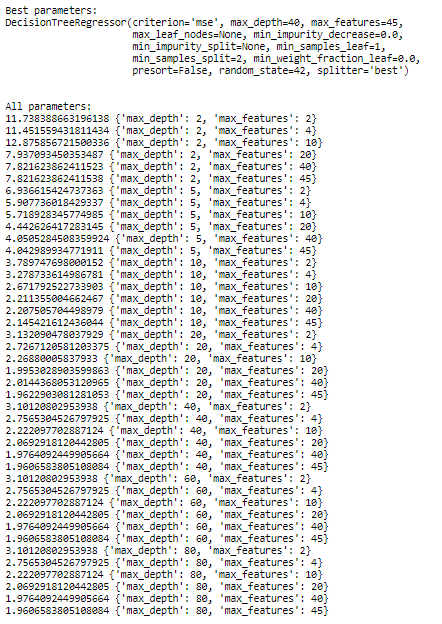

### Test Best Parameters Against Eachother

In [51]:
# Apply best hyper parameters to each of models
if run_live:
    #Train and fit on raw-unscaled data
    reg = DecisionTreeRegressor(max_depth=20, max_features=45,random_state=42)
    reg.fit(X_train, y_train)
    predictions = reg.predict(X_test)

    print('Absolute Error with Unscaled data')
    aberr = np.abs(predictions - y_test)
    print(pd.DataFrame(aberr).describe())

    X_e_rmse=rmse(predictions[:,0], y_test[:,0])
    X_v_rmse=rmse(predictions[:,1], y_test[:,1])
    print('\n')
    print('Elasticity RMSE: ', X_e_rmse)
    print('Viscosity RMSE: ', X_v_rmse)

    #Train and fit on scaled data
    reg = DecisionTreeRegressor(max_depth=40, max_features=45,random_state=42)
    reg.fit(X_scl_train, y_scl_train)
    predictions = reg.predict(X_scl_test)
    print('\n')
    print('Absolute Error with Scaled data')
    aberr = np.abs(predictions - y_scl_test)
    print(pd.DataFrame(aberr).describe())

    X_scl_e_rmse=rmse(predictions[:,0], y_scl_test[:,0])
    X_scl_v_rmse=rmse(predictions[:,1], y_scl_test[:,1])
    print('\n')
    print('Elasticity RMSE: ', rmse(predictions[:,0], y_scl_test[:,0]))
    print('Viscoscity RMSE: ', rmse(predictions[:,1], y_scl_test[:,1]))

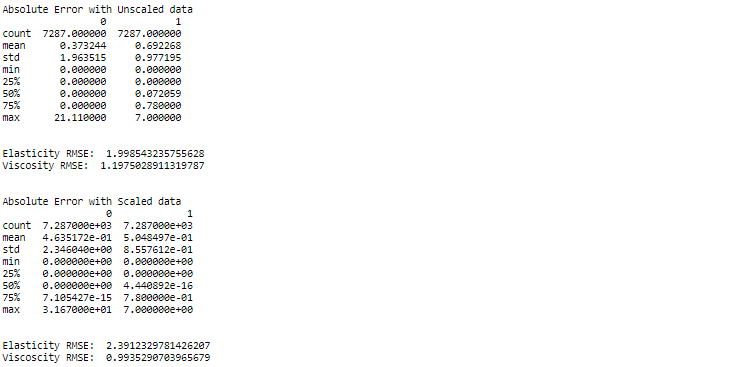

### Repeat For Random Forest

In [52]:
if run_live:
    from sklearn.ensemble import RandomForestRegressor

    e_rf_rmse=np.zeros(12)
    v_rf_rmse=np.zeros(12)
    numcomp=np.zeros(12)

    for ind in range(12):
        forest_reg = RandomForestRegressor(n_estimators=(ind)*4+1, random_state=42)

        forest_reg.fit(X_scl_train, y_scl_train)
        rf_predictions = forest_reg.predict(X_scl_test)

        e_rf_rmse[ind] = rmse(rf_predictions[:,0], y_scl_test[:,0])
        v_rf_rmse[ind] = rmse(rf_predictions[:,1], y_scl_test[:,1])
        numcomp[ind]=(ind)*4+1

    plt.figure(figsize=(15,10))
    ax = plt.subplot(2,1,1)
    ax.plot(numcomp, e_rf_rmse,label='RF')
    ax.plot([1, 45], X_e_rmse+[0, 0],label='Raw-Unscaled')
    ax.plot([1, 45], X_scl_e_rmse+[0, 0],label='Scaled')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Elasticity RMSE')
    ax.legend()
    ax2 = plt.subplot(2,1,2)
    ax2.plot(numcomp, v_rf_rmse,label='RF')
    ax2.plot([1, 45], X_v_rmse+[0, 0],label='Raw-Unscaled')
    ax2.plot([1, 45], X_scl_v_rmse+[0, 0],label='Scaled')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Viscosity RMSE')
    ax2.legend()
    plt.show()    

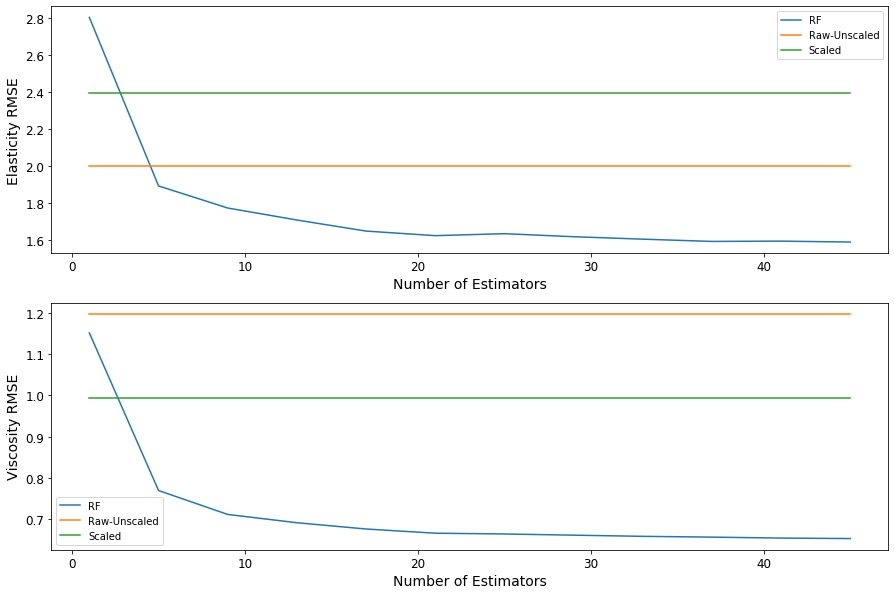

In [53]:
if run_live:
    print('Best Elasticity RMSE: ', e_rf_rmse[11])
    print('Best Viscoscity RMSE: ', v_rf_rmse[11])
else:
    print('Best Elasticity RMSE: 1.586341076407346')
    print('Best Viscoscity RMSE: 0.6525703312947085')

Best Elasticity RMSE: 1.586341076407346
Best Viscoscity RMSE: 0.6525703312947085


### Repeat For K Nearest Neighbors

In [54]:
if run_live:
    from sklearn.neighbors import KNeighborsRegressor as KNR

    e_knr_rmse=np.zeros(11)
    v_knr_rmse=np.zeros(11)
    numcomp=np.zeros(11)

    for ind in range(11):
        knr_reg = KNR(n_neighbors=(ind)*2+1)

        knr_reg.fit(X_scl_train, y_scl_train)
        knr_predictions = knr_reg.predict(X_scl_test)

        e_knr_rmse[ind] = rmse(knr_predictions[:,0], y_scl_test[:,0])
        v_knr_rmse[ind] = rmse(knr_predictions[:,1], y_scl_test[:,1])
        numcomp[ind]=(ind)*2+1

    plt.figure(figsize=(15,10))
    ax = plt.subplot(2,1,1)
    ax.plot(numcomp, e_knr_rmse,label='KNR')
    ax.plot([1, 21], X_e_rmse+[0, 0],label='Raw-Unscaled')
    ax.plot([1, 21], X_scl_e_rmse+[0, 0],label='Scaled')
    plt.xlabel('Nearest Neighbors')
    plt.ylabel('Elasticity RMSE')
    ax.legend()
    ax2 = plt.subplot(2,1,2)
    ax2.plot(numcomp, v_knr_rmse,label='KNR')
    ax2.plot([1, 21], X_v_rmse+[0, 0],label='Raw-Unscaled')
    ax2.plot([1, 21], X_scl_v_rmse+[0, 0],label='Scaled')
    plt.xlabel('Nearest Neighbors')
    plt.ylabel('Viscosity RMSE')
    ax2.legend()
    plt.show()    

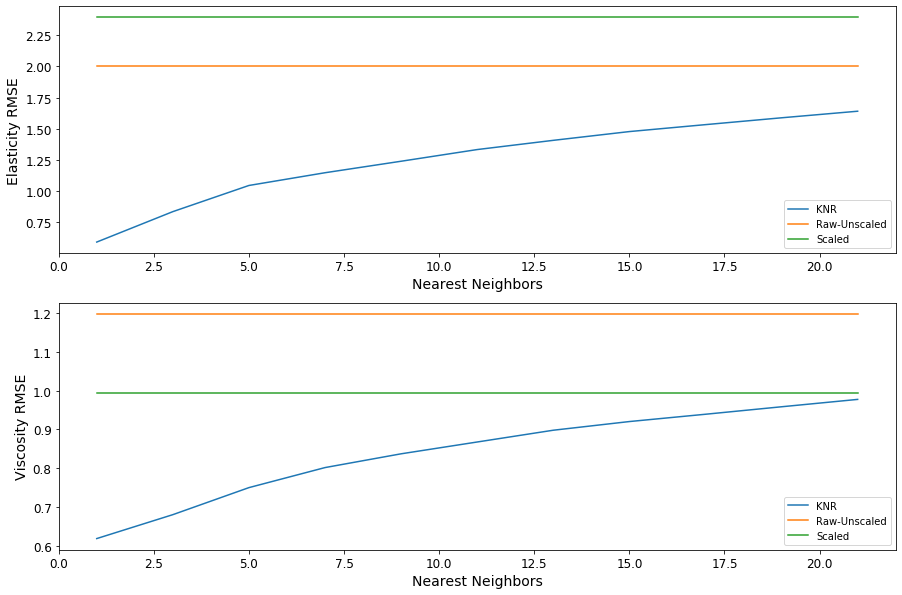

In [55]:
if run_live:
    print('Best Elasticity RMSE: ', e_knr_rmse[11])
    print('Best Viscoscity RMSE: ', v_knr_rmse[11])
else:
    print('Best Elasticity RMSE: 0.5930516775976261')
    print('Best Viscoscity RMSE: 0.6187408139662134')

Best Elasticity RMSE: 0.5930516775976261
Best Viscoscity RMSE: 0.6187408139662134


### Lasso, Elastic Net, and Ridge Regressors

In [56]:
if run_live:
    from sklearn.linear_model import Lasso

    alphas=[10, 1, .1, .01, .001, .0001, .00001]
    e_l_rmse=np.zeros(np.size(alphas))
    v_l_rmse=np.zeros(np.size(alphas))


    for ind in range(np.size(alphas)):
        reg = Lasso(alpha=alphas[ind])

        reg.fit(X_scl_train, y_scl_train)
        predictions = reg.predict(X_scl_test)

        e_l_rmse[ind] = rmse(predictions[:,0], y_scl_test[:,0])
        v_l_rmse[ind] = rmse(predictions[:,1], y_scl_test[:,1])

In [57]:
if run_live:
    from sklearn.linear_model import ElasticNet
    alphas=[10, 1, .1, .01, .001, .0001, .00001]
    e_el_rmse=np.zeros(np.size(alphas))
    v_el_rmse=np.zeros(np.size(alphas))


    for ind in range(np.size(alphas)):
        elastic_net = ElasticNet(alpha=alphas[ind], max_iter=1000, l1_ratio=0.1, random_state=42)

        elastic_net.fit(X_scl_train, y_scl_train)
        predictions = elastic_net.predict(X_scl_test)

        e_el_rmse[ind] = rmse(predictions[:,0], y_scl_test[:,0])
        v_el_rmse[ind] = rmse(predictions[:,1], y_scl_test[:,1])

In [58]:
if run_live:
    from sklearn.linear_model import Ridge

    alphas=[10, 1, .1, .01, .001, .0001, .00001]
    e_rr_rmse=np.zeros(np.size(alphas))
    v_rr_rmse=np.zeros(np.size(alphas))


    for ind in range(np.size(alphas)):
        reg = Ridge(alpha=alphas[ind], random_state=42)

        reg.fit(X_scl_train, y_scl_train)
        predictions = reg.predict(X_scl_test)

        e_rr_rmse[ind] = rmse(predictions[:,0], y_scl_test[:,0])
        v_rr_rmse[ind] = rmse(predictions[:,1], y_scl_test[:,1])

In [59]:
if run_live:
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2,1,1)
    ax.plot(np.log10(alphas), e_l_rmse,label='Lasso')
    ax.plot(np.log10(alphas), e_el_rmse,label='ElasticNet')
    ax.plot(np.log10(alphas), e_rr_rmse,label='RidgeReg')
    ax.plot([-5, 1], e_knr_rmse[0]+[0, 0],label='KNR Baseline')
    plt.xlabel('Log10(LearningRate)')
    plt.ylabel('Elasticity RMSE')
    ax.legend()
    ax2 = plt.subplot(2,1,2)
    ax2.plot(np.log10(alphas), v_l_rmse,label='Lasso')
    ax2.plot(np.log10(alphas), v_el_rmse,label='ElasticNet')
    ax2.plot(np.log10(alphas), v_rr_rmse,label='RidgeReg')
    ax2.plot([-5, 1], v_knr_rmse[0]+[0, 0],label='KNR Baseline')
    plt.xlabel('Log10(LearningRate)')
    plt.ylabel('Viscosity RMSE')
    ax2.legend()
    plt.show()    



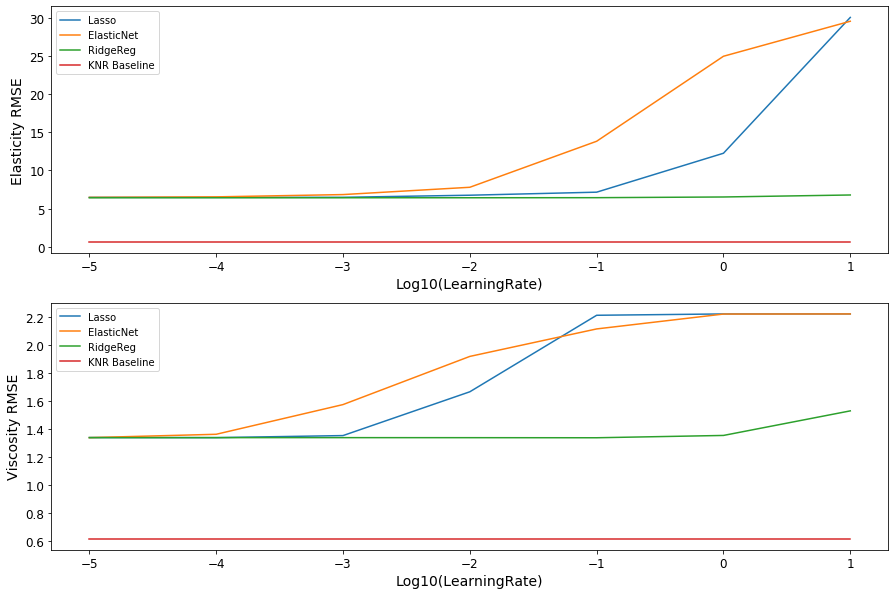

## Test Dimensionality Reduction Techniques

In [60]:
#View number of required components required to acheive CEV above 99.9%
if run_live:
    from sklearn.decomposition import PCA

    # Plot variance curve for all 45 components

    pca = PCA().fit(X_scl)
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance For All Components')

    # Plot variance curve only for components up to 99.9% variance
    pca2 = PCA(.999,random_state=42)
    q = pca2.fit_transform(X_scl)
    plt.subplot(122)
    q_scl_train, q_scl_test, y_train, y_test = train_test_split(q, y, test_size=0.33, random_state=42)
    plt.plot(np.cumsum(pca2.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance For Top 15 Components')
    plt.show()

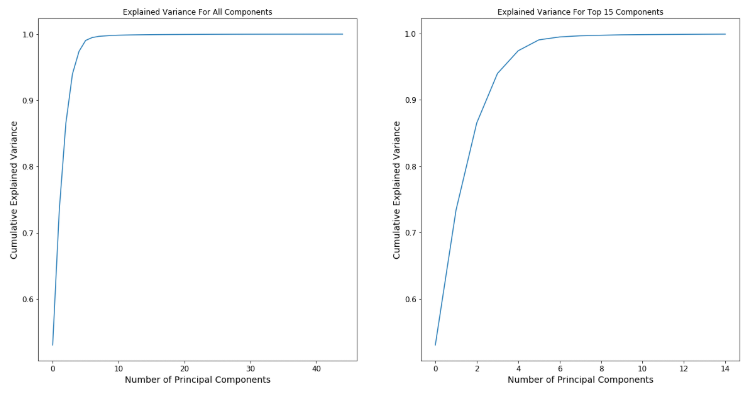

### PCA with KNR vs RF

In [61]:
# Use Grid Search CV to find the optimal KNN Parameter when doing PCA
if run_live:

    param_grid = [

        {'n_neighbors': [1, 2, 5, 10, 20, 40]},
      ]

    knr_reg = KNR()
    grid_search = GridSearchCV(knr_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)

    pca2 = PCA(.999,random_state=42)
    q = pca2.fit_transform(X_scl)

    q_train, q_test, y_q_train, y_q_test = train_test_split(q, y, test_size=0.2, random_state=42)


    grid_search.fit(q_train, y_q_train)

    print('Best parameters:')
    print(grid_search.best_estimator_)
    print('\n')
    print('All parameters:')
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

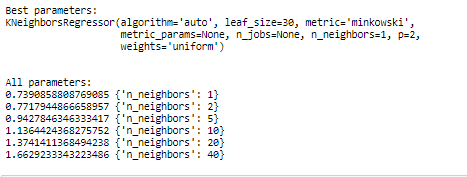

In [62]:
# Use Grid Search CV to find the optimal RF Parameter when doing PCA
if run_live:
    param_grid = [

        {'n_estimators': [2, 5, 10, 20, 30, 40]},
      ]

    forest_reg = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)

    pca2 = PCA(.999,random_state=42)
    q = pca2.fit_transform(X_scl)

    q_train, q_test, y_q_train, y_q_test = train_test_split(q, y, test_size=0.2, random_state=42)

    grid_search.fit(q_train, y_q_train)

    print('Best parameters:')
    print(grid_search.best_estimator_)
    print('\n')
    print('All parameters:')
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

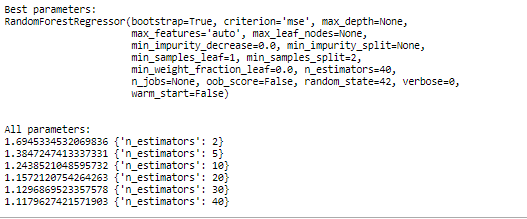

In [63]:
# Test RMSE of Fit vs Number Components because KNR yields lowest RMSE, Test with PCA
if run_live:
    e_rmse=np.zeros(45)
    v_rmse=np.zeros(45)
    numcomp=np.zeros(45)

    for ind in range(45):
        pca2 = PCA(n_components=ind+1,random_state=42)
        q = pca2.fit_transform(X_scl)

        q_train, q_test, y_q_train, y_q_test = train_test_split(q, y, test_size=0.2, random_state=42)

        reg = KNR(n_neighbors=1)
        reg.fit(q_train, y_q_train)

        predictions = reg.predict(q_test)
        e_rmse[ind] = rmse(predictions[:,0], y_q_test[:,0])
        v_rmse[ind] = rmse(predictions[:,1], y_q_test[:,1])
        numcomp[ind] = ind+1

    plt.figure(figsize=(15,10))
    ax = plt.subplot(2,1,1)
    ax.plot(numcomp, e_rmse,label='PCA')
    ax.plot([0,45], e_knr_rmse[0]+[0, 0],label='KNR Baseline')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Elasticity RMSE')
    ax.legend()
    ax2 = plt.subplot(2,1,2)
    ax2.plot(numcomp, v_rmse,label='PCA')
    ax2.plot([0,45], v_knr_rmse[0]+[0, 0],label='KNR Baseline')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Viscosity RMSE')
    ax2.legend()
    plt.show()

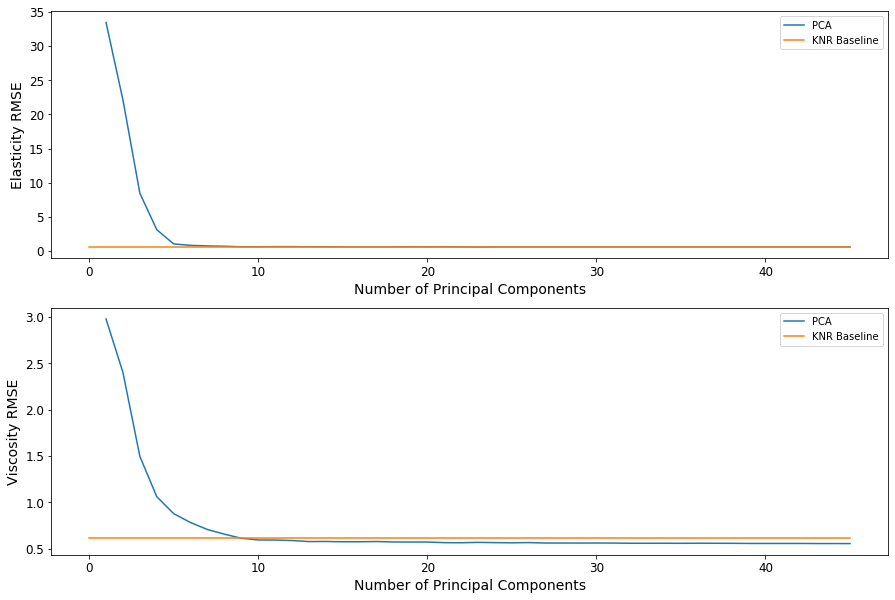

In [64]:
if run_live==True:
    print('Elasticity RMSE at 30 components: ', e_rmse[29])
    print('Viscoscity RMSE at 30 components: ', v_rmse[29])

else:
    print('Elasticity RMSE at 30 components: 0.6151812615818603')
    print('Viscoscity RMSE at 30 components: 0.561694088534144')

Elasticity RMSE at 30 components: 0.6151812615818603
Viscoscity RMSE at 30 components: 0.561694088534144


In [65]:
if run_live:
    from sklearn.decomposition import KernelPCA, IncrementalPCA
    from sklearn.manifold import LocallyLinearEmbedding
    from sklearn.manifold import MDS
    from sklearn.manifold import Isomap
    from sklearn.manifold import TSNE
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [66]:
# Test RMSE of Fit for Incremental PCA vs Number Components
if run_live:
    n_batches = 100
    e_incpca_rmse=np.zeros(45)
    v_incpca_rmse=np.zeros(45)

    numcomp=np.zeros(45)
    for components in range(45):
        inc_pca = IncrementalPCA(n_components=components+1)
        for X_batch in np.array_split(X_scl, n_batches):
            print(".", end="") # not shown in the book
            inc_pca.partial_fit(X_batch)

        X_reduced = inc_pca.transform(X_scl)

        X_incpca_train, X_incpca_test, y_incpca_train, y_incpca_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

        reg = KNR(n_neighbors=1)
        reg.fit(X_incpca_train, y_incpca_train)

        predictions = reg.predict(X_incpca_test)
        e_incpca_rmse[components] = rmse(predictions[:,0], y_incpca_test[:,0])
        v_incpca_rmse[components] = rmse(predictions[:,1], y_incpca_test[:,1])
        numcomp[components]=components+1

    plt.figure(figsize=(15,10))
    ax=plt.subplot(2,1,1)
    ax.plot(numcomp, e_incpca_rmse,label='Inc-PCA')
    ax.plot(numcomp, e_rmse,label='PCA')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Elasticity RMSE')
    ax.legend()
    ax2=plt.subplot(2,1,2)
    ax2.plot(numcomp,v_incpca_rmse,label='Inc-PCA')
    ax2.plot(numcomp, v_rmse,label='PCA')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Viscosity RMSE')
    ax2.legend()
    plt.show()

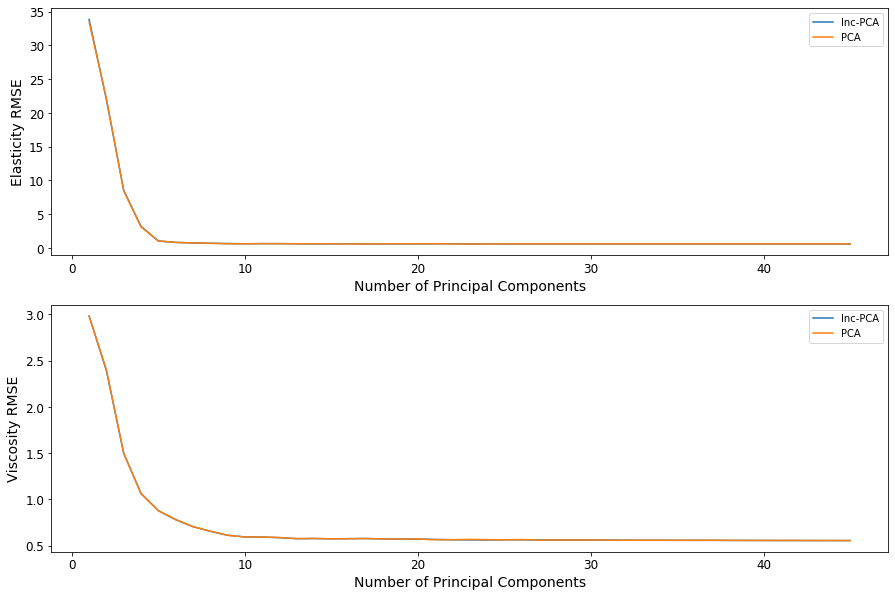

### RBF vs Sigmoid Kernel PCA

In [67]:
# Trying RBF Kernel PCA
if run_live:
    n_batches = 100
    e_kerpca_rmse=np.zeros(12)
    v_kerpca_rmse=np.zeros(12)
    numcomp2=np.zeros(12)
    for components in range(12):
        print(components)
        rbf_pca = KernelPCA(n_components = (components)*4+1, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)


        X_reduced = rbf_pca.fit_transform(X_scl)

        X_incpca_train, X_incpca_test, y_incpca_train, y_incpca_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

        reg = KNR(n_neighbors=1)
        reg.fit(X_incpca_train, y_incpca_train)

        predictions = reg.predict(X_incpca_test)
        e_kerpca_rmse[components] = rmse(predictions[:,0], y_incpca_test[:,0])
        v_kerpca_rmse[components] = rmse(predictions[:,1], y_incpca_test[:,1])
        numcomp2[components] = (components)*4+1


In [68]:
# Trying Sigmoid Kernel PCA
if run_live:
    n_batches = 100
    e_skerpca_rmse=np.zeros(12)
    v_skerpca_rmse=np.zeros(12)

    for components in range(12):
        print(components)
        sig_pca = KernelPCA(n_components = (components)*4+1, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


        X_reduced = sig_pca.fit_transform(X_scl)

        X_incpca_train, X_incpca_test, y_incpca_train, y_incpca_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

        reg = KNR(n_neighbors=1)
        reg.fit(X_incpca_train, y_incpca_train)

        predictions = reg.predict(X_incpca_test)
        e_skerpca_rmse[components] = rmse(predictions[:,0], y_incpca_test[:,0])
        v_skerpca_rmse[components] = rmse(predictions[:,1], y_incpca_test[:,1])


### Isomap

In [69]:
# Trying Isomap
if run_live:
    n_batches = 100
    e_isopca_rmse=np.zeros(12)
    v_isopca_rmse=np.zeros(12)

    for components in range(12):
        print(components)
        isom = Isomap(n_components = (components)*4+1)


        X_reduced = isom.fit_transform(X_scl)

        X_incpca_train, X_incpca_test, y_incpca_train, y_incpca_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

        reg = KNR(n_neighbors=1)
        reg.fit(X_incpca_train, y_incpca_train)

        predictions = reg.predict(X_incpca_test)
        e_isopca_rmse[components] = rmse(predictions[:,0], y_incpca_test[:,0])
        v_isopca_rmse[components] = rmse(predictions[:,1], y_incpca_test[:,1])

## Cross Comparison of PCA Methods 

In [70]:
if run_live:
    plt.figure(figsize=(10,10))
    ax = plt.subplot(2,1,1)
    plt.plot(numcomp2, e_kerpca_rmse,label='RBF Kernel-PCA')
    plt.plot(numcomp2, e_skerpca_rmse,label='Sigmoid Kernel-PCA')
    plt.plot(numcomp2, e_isopca_rmse,label='Isomap')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Elasticity RMSE')
    ax.legend()
    ax2 = plt.subplot(2,1,2)
    plt.plot(numcomp2, v_kerpca_rmse,label='RBF Kernel-PCA')
    plt.plot(numcomp2, v_skerpca_rmse,label='Sigmoid Kernel-PCA')
    plt.plot(numcomp2, v_isopca_rmse,label='Isomap')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Viscosity RMSE')
    ax2.legend()
    plt.show()

if run_live:
    print('Summary Stats')
    print('***')
    print('RBF Kernel PCA')
    print('Elasticity RMSE at 33 components: ', e_kerpca_rmse[9])
    print('Viscosity RMSE at 33 components: ', v_kerpca_rmse[9])
    print('***')
    print('Sigmoid Kernel PCA')
    print('Elasticity RMSE at 33 components: ', e_skerpca_rmse[9])
    print('Viscosity RMSE at 33 components: ', v_skerpca_rmse[9])
    print('***')
    print('Isomap')
    print('Elasticity RMSE at 33 components: ', e_isopca_rmse[9])
    print('Viscosity RMSE at 33 components: ', v_isopca_rmse[9])
else:
    print('Summary Stats')
    print('***')
    print('RBF Kernel PCA')
    print('Elasticity RMSE at 33 components: 0.6549080309367928')
    print('Viscosity RMSE at 33 components: 0.5658236349513559')
    print('***')
    print('Sigmoid Kernel PCA')
    print('Elasticity RMSE at 33 components: 0.5726636331873731')
    print('Viscosity RMSE at 33 components: 0.5527198886979904')
    print('***')
    print('Isomap')
    print('Elasticity RMSE at 33 components: 2.1071269300771895')
    print('Viscosity RMSE at 33 components: 0.9425060786718212')
    

Summary Stats
***
RBF Kernel PCA
Elasticity RMSE at 33 components: 0.6549080309367928
Viscosity RMSE at 33 components: 0.5658236349513559
***
Sigmoid Kernel PCA
Elasticity RMSE at 33 components: 0.5726636331873731
Viscosity RMSE at 33 components: 0.5527198886979904
***
Isomap
Elasticity RMSE at 33 components: 2.1071269300771895
Viscosity RMSE at 33 components: 0.9425060786718212


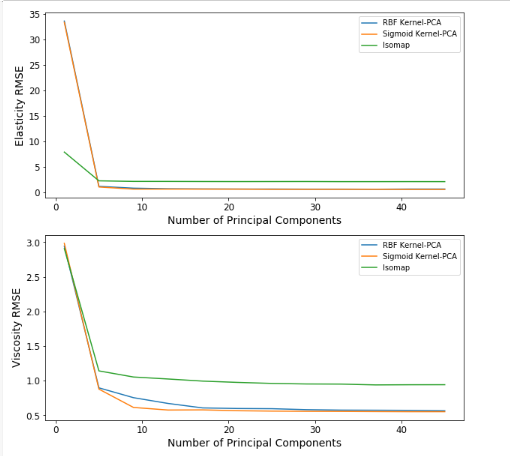

# Fully Connected Neural Networks

## Load Data and Preprocessing

In [ ]:
data = loadmat('datasets/dataset_100samples_minmax.mat')['data']

# Same preprocessing as for sklearn regressors
X = data[:,0:45]   # time-series of ultrasonically tracked displacement + axial position + focus
y = data[:,45:47]  # elasticity, viscosity

# Normalize displacements along each row
disp_sc = MinMaxScaler()
disps = X[:,0:42]
disps = disp_sc.fit_transform(disps.T).T
X[:,0:42] = disps

# Normalize axial depth and focal depth columns
sc = MinMaxScaler()
X[:,43:45] = sc.fit_transform(X[:,43:45])

# Normalize outputs
y_sc = MinMaxScaler()
y = y_sc.fit_transform(y)

## Training Helper Functions

In [8]:
from sklearn.model_selection import train_test_split

Xsamp, Xtest, Ysamp, Ytest = train_test_split(X, y, test_size=0.03, random_state=42)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def judgeQVISR( guesses, truth, scaler=y_sc, verbose=0 ):
    absErr = np.abs( guesses - truth )                   # find tendencies for absolute error of predictions
    e_rmse_norm = rmse(guesses[:,0], truth[:,0])         # calculate RMSE of normalized predictions
    v_rmse_norm = rmse(guesses[:,1], truth[:,1])
    guess_denorm = scaler.inverse_transform(guesses)     # perform inverse of normalization
    truth_denorm = scaler.inverse_transform(truth)
    e_rmse = rmse(guess_denorm[:,0], truth_denorm[:,0])  # calculate RMSE of de-normalized predictions
    v_rmse = rmse(guess_denorm[:,1], truth_denorm[:,1])
    if verbose>=1:
        # take descriptive statistics of estimated elasticities and viscosities
        df_err=pd.DataFrame(absErr, columns=['Norm. Elast.', 'Norm. Visc.'])
        df_err=df_err.round(3)
        print('Absolute Error:\n', df_err.describe(), '\n')

        # print normalized and de-normalized estimate RMSEs
        print('Normalized Elast. RMSE: {:.3f}'.format(e_rmse_norm) )
        print('Normalized Visco. RMSE: {:.3f}'.format(v_rmse_norm) )
        print('      True Elast. RMSE: {:.3f} kPa'.format(e_rmse) )
        print('      True Visco. RMSE: {:.3f} Pa-s'.format(v_rmse) )
    
    return guess_denorm, (e_rmse,v_rmse)

def trainNN(datX, datY, nn_model, nn_crita, nn_optim, verbose=0):
    
    # explicitly set inputted model in Training Mode
    nn_model.train()
    
    # find number of datapoints per sample
    Npts=datX.cpu().detach().numpy().shape[1]
    
    # start timing duration of single epoch of training
    tEpoch=time.time()
    
    for i, datIn, datOut in zip(range(Npts), datX, datY):
        
        # reset gradient so that gradients do not accumulate
        nn_optim.zero_grad()
        
        # pass data forward through the model
        outputs=nn_model(datIn)
        
        # calculate performance criteria for this sample
        loss=nn_crita(outputs, datOut)
        
        # backpropagate loss function
        loss.backward()
        
        # apply change to neuron weights
        nn_optim.step()
    
    if verbose==1:
        print('Model training complete ({:.2f} s elapsed)'.format(time.time()-tEpoch))
    return loss.item()

def validateNN(datX, datY, nn_model, nn_crita, scaler, verbose=0):
    
    # explicitly set inputted model in Evaluation Mode
    nn_model.eval()
    
    # initialize reference variables
    Nsamp=np.size(datY.cpu().detach().numpy(),0)
    guessGPU=[]
    
    # start timing duration of all training epochs
    if verbose>0:
        tEpoch=time.time()
    
    # initialize running-sum of processing time per sample
    if verbose>=3:
        tCMA=0
        nCMA=0
    
    for i, datIn, datOut in zip(range(Nsamp), datX, datY):
        
        # initialize timer for training this instance
        if verbose>=3:
            tThis=time.time()
            nCMA=nCMA+1
        
        # pass data forward through the model, then force model output to rank-2
        outputs=nn_model(datIn)
        guessNow=outputs.view(1,-1)
        
        # calculate performance criteria for this sample
        loss=nn_crita(outputs, datOut)
        
        guessGPU=guessNow if i==0 else torch.cat((guessGPU,guessNow), dim=0)
        
        # take cumulative moving average of model fit time
        if verbose>=3:
            tCMA=( (time.time()-tThis)+(nCMA-1)*tCMA )/nCMA
    
    if verbose>=2:
        print('{:.1f} s: neural network fit'.format(time.time()-tEpoch))
    
    if verbose>=3:
        print('cum moving avg {:.3f} ms/sample'.format(1000*tCMA))
    
    # transfer estimates from VRAM to RAM
    guesses=guessGPU.cpu().detach().numpy()
    
    # de-normalize predictions, and assess performance
    if verbose>=4:
        guess,err=judgeQVISR(guesses, datY.cpu().detach().numpy(), scaler=scaler, verbose=True)
    else:
        guess,err=judgeQVISR(guesses, datY.cpu().detach().numpy(), scaler=scaler, verbose=False)
    
    tNow=time.time()
    if verbose>=1:
        print('RMSE = {:.2f} kPa / {:.2f} Pa-s ({:.1f} s elapsed)'
              .format(err[0], err[1], tNow-tEpoch))
    
    return guess, loss.item(), err

## Arbitrary Single-Layer DNN

In [13]:
class dnn1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(dnn1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu= nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 2)
    
    def forward(self, x):
        out_fc1 = self.fc1(x)
        out_re1 = self.relu(out_fc1)
        out_fc2 = self.fc2(out_re1)
        return out_fc2
    
sizeI=np.size(Xsamp,1)                                # define network
size1=100
criterion=nn.MSELoss()                                # define loss function
model=dnn1(sizeI, size1).to(device)                   # define model
optimizer=torch.optim.SGD(model.parameters(), lr=0.1) # define optimizer scheme

In [15]:
nEpochs=25

# set training dataset
Xa=torch.Tensor(Xsamp).to(device).requires_grad_()
Ya=torch.Tensor(Ysamp).to(device).requires_grad_()

# set validation dataset
Xb=torch.Tensor(Xtest).to(device)
Yb=torch.Tensor(Ytest).to(device)

# initialize storage variables for estimate errors
errorsLT=np.zeros((nEpochs,1))
errorsLV=np.zeros((nEpochs,1))
errorsEM=np.zeros((nEpochs,1))
errorsVM=np.zeros((nEpochs,1))

scaler=y_sc # handle to normalizer (sklearn)

for epoch in range(nEpochs):
    lossT=trainNN(Xa, Ya, model, criterion, optimizer, verbose=0)       # train model
    _,lossV,err=validateNN(Xb, Yb, model, criterion, scaler, verbose=1) # test model
    errorsLT[epoch]=lossT # save errors
    errorsLV[epoch]=lossV
    errorsEM[epoch]=err[0]
    errorsVM[epoch]=err[1]

RMSE = 36.55 kPa / 2.65 Pa-s (3.4 s elapsed)
RMSE = 35.42 kPa / 2.63 Pa-s (3.9 s elapsed)
RMSE = 33.77 kPa / 2.65 Pa-s (3.3 s elapsed)
RMSE = 33.30 kPa / 2.67 Pa-s (4.3 s elapsed)
RMSE = 31.73 kPa / 2.65 Pa-s (3.3 s elapsed)
RMSE = 32.59 kPa / 2.65 Pa-s (3.3 s elapsed)
RMSE = 31.31 kPa / 2.66 Pa-s (3.6 s elapsed)
RMSE = 30.42 kPa / 2.69 Pa-s (3.4 s elapsed)
RMSE = 30.17 kPa / 2.68 Pa-s (3.3 s elapsed)
RMSE = 28.93 kPa / 2.68 Pa-s (3.5 s elapsed)
RMSE = 30.14 kPa / 2.69 Pa-s (3.4 s elapsed)
RMSE = 28.46 kPa / 2.72 Pa-s (3.9 s elapsed)
RMSE = 29.28 kPa / 2.70 Pa-s (3.6 s elapsed)
RMSE = 27.80 kPa / 2.73 Pa-s (3.4 s elapsed)
RMSE = 27.51 kPa / 2.79 Pa-s (3.5 s elapsed)
RMSE = 26.83 kPa / 2.78 Pa-s (3.5 s elapsed)
RMSE = 26.15 kPa / 2.82 Pa-s (3.4 s elapsed)
RMSE = 25.53 kPa / 2.83 Pa-s (3.3 s elapsed)
RMSE = 25.90 kPa / 2.86 Pa-s (3.6 s elapsed)
RMSE = 25.83 kPa / 2.94 Pa-s (3.3 s elapsed)
RMSE = 26.21 kPa / 3.07 Pa-s (3.3 s elapsed)
RMSE = 25.10 kPa / 2.94 Pa-s (3.6 s elapsed)
RMSE = 24.

<function matplotlib.pyplot.show(*args, **kw)>

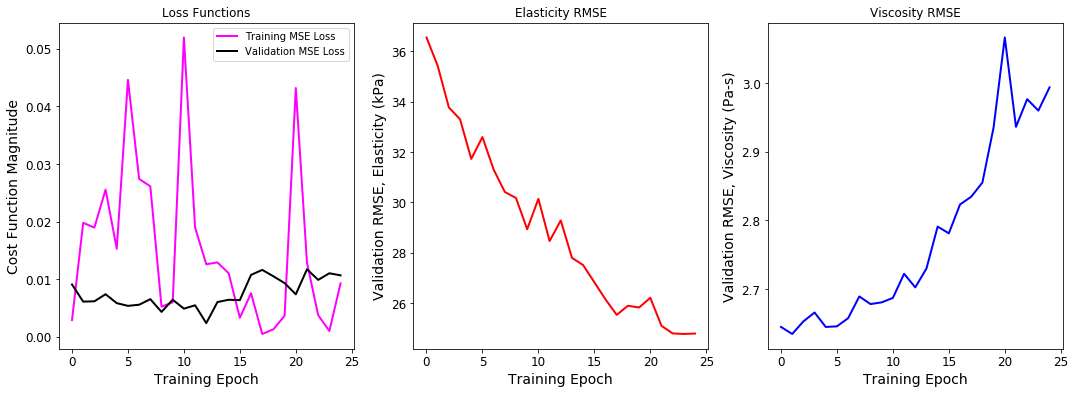

In [16]:
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.title('Loss Functions')
errLT=plt.plot(range(nEpochs), errorsLT, color='magenta', linewidth=2, label='Training MSE Loss')
errLV=plt.plot(range(nEpochs), errorsLV, color='black', linewidth=2, label='Validation MSE Loss')
plt.xlabel('Training Epoch')
plt.ylabel('Cost Function Magnitude')
plt.legend()

plt.subplot(132)
plt.title('Elasticity RMSE')
plt.plot(range(nEpochs), errorsEM, color='red', linewidth=2)
plt.xlabel('Training Epoch')
plt.ylabel('Validation RMSE, Elasticity (kPa)')

plt.subplot(133)
plt.title('Viscosity RMSE')
plt.plot(range(nEpochs), errorsVM, color='blue', linewidth=2)
plt.xlabel('Training Epoch')
plt.ylabel('Validation RMSE, Viscosity (Pa-s)')

plt.show

## Investigating DNN Architecture/Layer Sizes

In [17]:
def trainManyNN(modelDict, nEpoch, nn_crita, learnrate):

    # initialize storage variables for estimate errors
    errorsLT=np.zeros((nEpoch, len(modelDict)))
    errorsLV=np.zeros((nEpoch, len(modelDict)))
    errorsEM=np.zeros((nEpoch, len(modelDict)))
    errorsVM=np.zeros((nEpoch, len(modelDict)))

    scaler=y_sc # handle to normalizer (sklearn)

    for cand, modelID, modelCPU in zip( range(len(modelDict)),  modelDict.keys(),  modelDict.values() ):

        # start measuring computation time for assessing this network
        tCand=time.time()

        # transfer current model to GPU
        modelNow=modelCPU.to(device)

        # set optimization scheme
        optimizer=torch.optim.SGD(modelNow.parameters(), lr=learnrate)

        # set training dataset
        Xa=torch.Tensor(Xsamp).to(device).requires_grad_()
        Ya=torch.Tensor(Ysamp).to(device).requires_grad_()

        # set validation dataset
        Xb=torch.Tensor(Xtest).to(device)
        Yb=torch.Tensor(Ytest).to(device)

        for epoch in range(nEpoch):
            lossT=trainNN(Xa, Ya, modelNow, nn_crita, optimizer, verbose=0)       # train model
            _,lossV,err=validateNN(Xb, Yb, modelNow, nn_crita, scaler, verbose=0) # test model

            errorsLT[epoch,cand]=lossT # save errors
            errorsLV[epoch,cand]=lossV
            errorsEM[epoch,cand]=err[0]
            errorsVM[epoch,cand]=err[1]

        # display name of current model on console
        print(modelID, '--- model', cand+1, 'of', len(models), 'analyzed in', round(time.time()-tCand, 2), 's')
    
    # plot performance of model
    return errorsLT, errorsLV, errorsEM, errorsVM

def assessManyNN(modelDict, nEpoch, lossTrain, lossValid, errorE, errorV):
    
    plt.figure(figsize=(12,16))
    ax1=plt.subplot(511);   ax2=plt.subplot(523);   ax3=plt.subplot(524);
    ax1.set_title('Loss Functions');  ax1.set_xlabel('Training Epoch'); ax1.set_ylabel('Normalized MSE')
    ax2.set_title('Elasticity RMSE'); ax2.set_xlabel('Training Epoch'); ax2.set_ylabel('RMSE, Elasticity (kPa)')
    ax3.set_title('Viscosity RMSE');  ax3.set_xlabel('Training Epoch'); ax3.set_ylabel('RMSE, Viscosity (Pa-s)')

    for cand in range(len(modelDict)):
        errorNowLT=lossTrain[:,cand]
        errorNowLV=lossValid[:,cand]
        errorNowEM=errorE[:,cand]
        errorNowVM=errorV[:,cand]

        ax1.plot(range(nEpoch), errorNowLT, color='magenta', linewidth=2)
        ax1.plot(range(nEpoch), errorNowLV, color='black', linewidth=2)
        ax2.plot(range(nEpoch), errorNowEM, color='red', linewidth=2)
        ax3.plot(range(nEpoch), errorNowVM, color='blue', linewidth=2)

    plt.subplot(513)
    plt.title('Minimum Elasticity RMSE per DNN Architecture')
    plt.bar(range(len(modelDict)), errorE.min(axis=0), color='red')
    plt.xticks(range(len(modelDict)), modelDict.keys(), size='small', rotation='vertical')
    plt.ylabel('RMSE, Elasticity (kPa)')
    plt.ylim(np.maximum(0,  0.8*errorE.min()),
             np.minimum(30, 1.2*errorE.min(axis=0).max()) )
    
    plt.subplot(515)
    plt.title('Minimum Viscosity RMSE per DNN Architecture')
    plt.bar(range(len(modelDict)), errorV.min(axis=0), color='blue')
    plt.xticks(range(len(modelDict)), modelDict.keys(), size='small', rotation='vertical')
    plt.ylabel('RMSE, Viscosity (Pa-s)')
    plt.ylim(np.maximum(0, 0.8*errorV.min()),
             np.minimum(3, 1.2*errorV.min(axis=0).max()) )

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show

### Two-layer DNN only
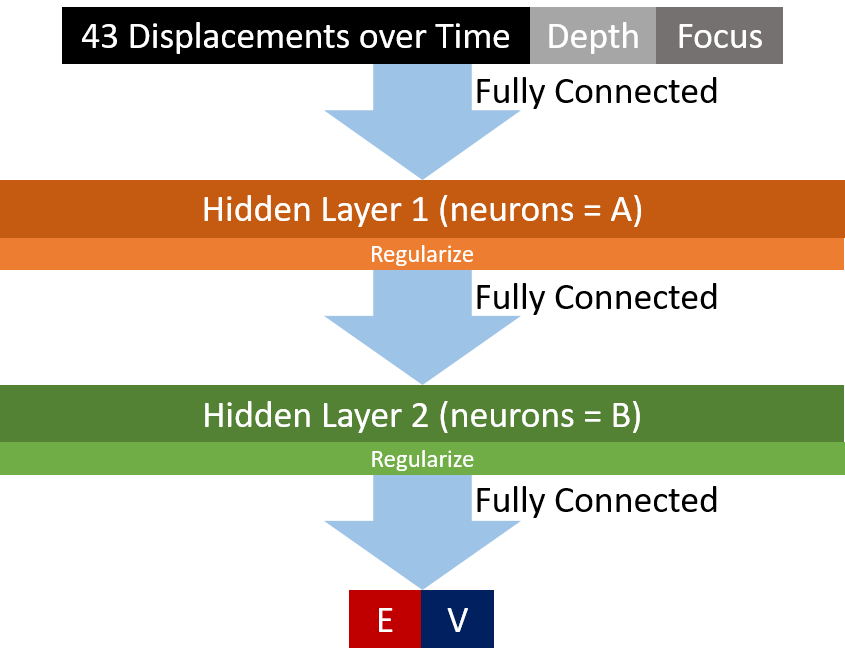

In [19]:
class dnn2(nn.Module):
    def __init__(self, input_size, hidden1, hidden2):
        super(dnn2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.re1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.re2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, 2)
    
    def forward(self, x):
        out_fc1 = self.fc1(x)
        out_re1 = self.re1(out_fc1)
        out_fc2 = self.fc2(out_re1)
        out_re2 = self.re2(out_fc2)
        out_fc3 = self.fc3(out_re2)
        return out_fc3

A=30, B=50 --- model 1 of 5 analyzed in 122.54 s
A=50, B=50 --- model 2 of 5 analyzed in 118.37 s
A=100, B=50 --- model 3 of 5 analyzed in 116.48 s
A=100, B=30 --- model 4 of 5 analyzed in 118.53 s
A=100, B=10 --- model 5 of 5 analyzed in 117.5 s


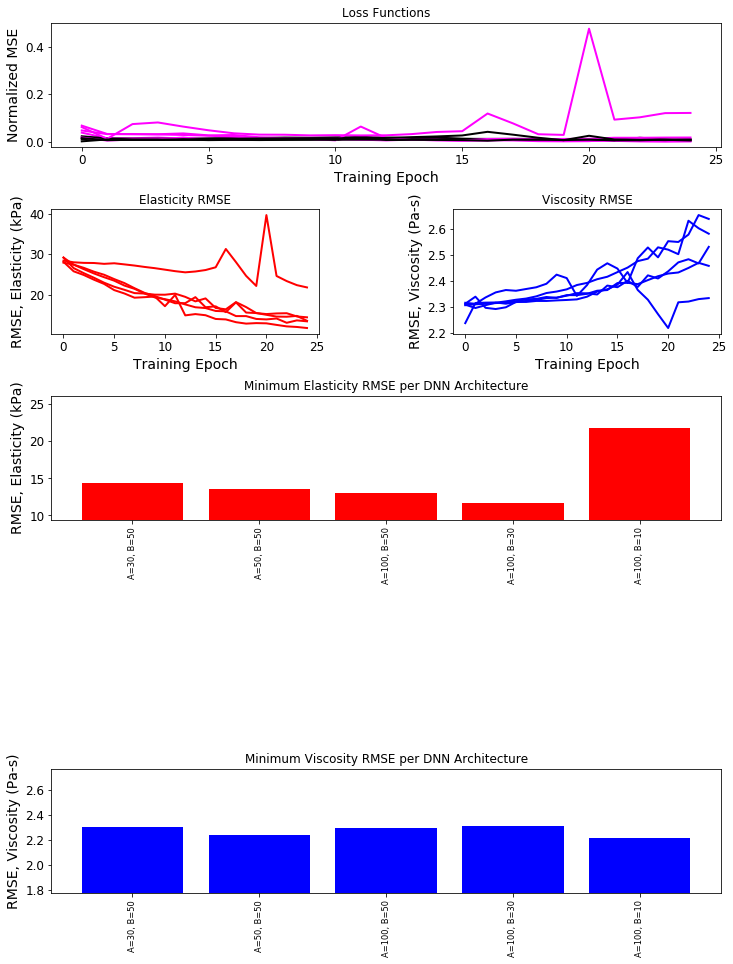

In [20]:
sizeI=np.size(Xsamp,1)
models={'A=30, B=50': dnn2(sizeI, 30,  50),
        'A=50, B=50': dnn2(sizeI, 50,  50),
        'A=100, B=50': dnn2(sizeI, 100, 50),
        'A=100, B=30': dnn2(sizeI, 100, 30),
        'A=100, B=10': dnn2(sizeI, 100, 10) }

# define loss function and optimizer learning rate
criterion=nn.MSELoss()
LR=0.1

# configure training
nEpochs=25

# try out "models"
LT,LV,EM,VM=trainManyNN(models, nEpochs, criterion, LR)
assessManyNN(models, nEpochs, LT, LV, EM, VM)

### Two-layer DNN + skip for focal depth/axial position
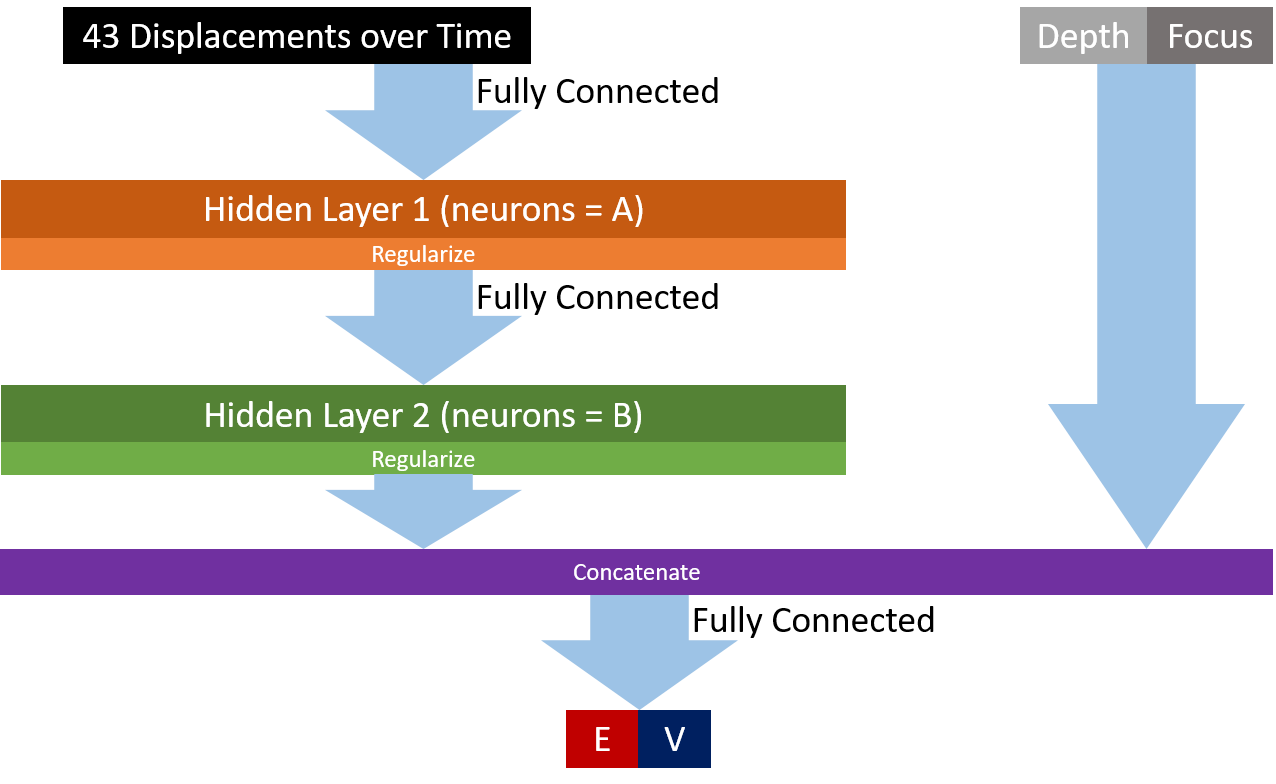

In [21]:
class dnn3(nn.Module):
    def __init__(self, input_size, hidden1, hidden2):
        super(dnn3, self).__init__()
        self.fc1 = nn.Linear(input_size-2, hidden1) # input to hidden 1
        self.re1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)      # hidden 1 to hidden 2/concatenation
        self.re2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2+2, 2)          # concatenation to output
    
    def forward(self, x):
        in_disp = x[:-2]                            # isolate out displacement profile
        in_meta = x[-2:]                            # isolate out focal depth + axial position
        out_fc1 = self.fc1(in_disp)                 # fully-connected 1 (displ. prof.) to hidden layer 1
        out_re1 = self.re1(out_fc1)
        out_fc2 = self.fc2(out_re1)                 # fully-connected 2 (displ. prof.) to hidden layer 2
        out_re2 = self.re2(out_fc2)
        out_cat = torch.cat((out_fc2, in_meta))     # concatenate and fully connect to output layer
        out_all = self.fc3(out_cat)
        return out_all

A=30, B=50 --- model 1 of 5 analyzed in 138.28 s
A=50, B=50 --- model 2 of 5 analyzed in 134.12 s
A=100, B=50 --- model 3 of 5 analyzed in 137.76 s
A=100, B=30 --- model 4 of 5 analyzed in 136.82 s
A=100, B=10 --- model 5 of 5 analyzed in 137.54 s


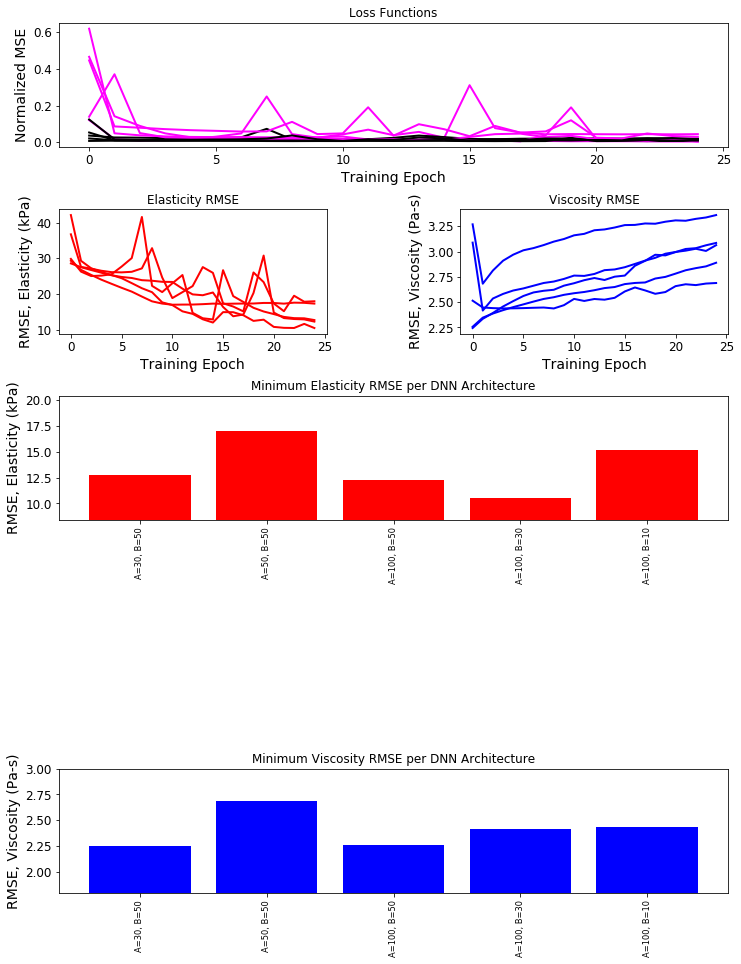

In [24]:
sizeI=np.size(Xsamp,1)
models={'A=30, B=50': dnn3(sizeI, 30,  50),
        'A=50, B=50': dnn3(sizeI, 50,  50),
        'A=100, B=50': dnn3(sizeI, 100, 50),
        'A=100, B=30': dnn3(sizeI, 100, 30),
        'A=100, B=10': dnn3(sizeI, 100, 10) }

# define loss function and optimizer learning rate
criterion=nn.MSELoss()
LR=0.1

# configure training
nEpochs=25

# try out "models"
LT,LV,EM,VM=trainManyNN(models, nEpochs, criterion, LR)
assessManyNN(models, nEpochs, LT, LV, EM, VM)

### Two-layer DNN + skip for focal depth/axial position + additional hidden layer
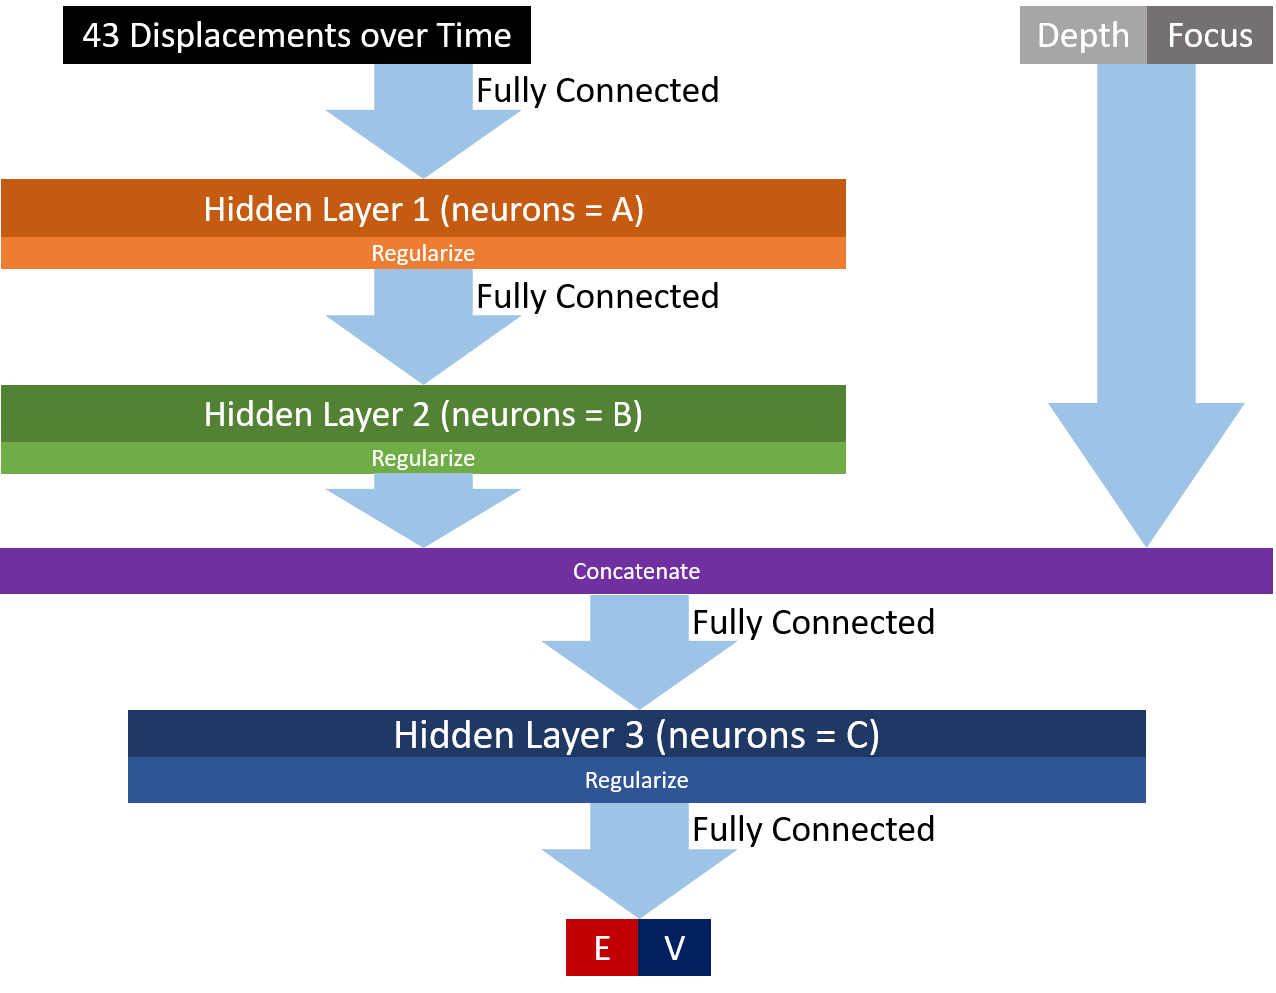

In [ ]:
class dnn4(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3):
        super(dnn4, self).__init__()
        self.fc1 = nn.Linear(input_size-2, hidden1) # input to hidden 1
        self.re1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)      # hidden 1 to hidden 2/concatenation
        self.re2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2+2, hidden3)    # concatenation to hidden 3
        self.re3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3, 2)            # hidden 3 to output
    
    def forward(self, x):
        in_disp = x[:-2]                            # isolate out displacement profile
        in_meta = x[-2:]                            # isolate out focal depth + axial position
        out_fc1 = self.fc1(in_disp)                 # fully-connected 1 (displ. prof.) to hidden layer 1
        out_re1 = self.re1(out_fc1)
        out_fc2 = self.fc2(out_re1)                 # fully-connected 2 (displ. prof.) to hidden layer 2
        out_re2 = self.re2(out_fc2)
        out_cat = torch.cat((out_fc2, in_meta))     # concatenate and fully connect to hidden layer 3
        out_fc3 = self.fc3(out_cat)
        out_re3 = self.re3(out_fc3)
        out_all = self.fc4(out_re3)                 # fully-connected 3 to output
        return out_all

A=30, B=50, C=50 --- model 1 of 10 analyzed in 168.05 s
A=50, B=50, C=50 --- model 2 of 10 analyzed in 166.08 s
A=100, B=50, C=50 --- model 3 of 10 analyzed in 163.55 s
A=100, B=50, C=30 --- model 4 of 10 analyzed in 164.26 s
A=100, B=50, C=10 --- model 5 of 10 analyzed in 164.42 s
A=100, B=30, C=5 --- model 6 of 10 analyzed in 168.99 s
A=100, B=100, C=10 --- model 7 of 10 analyzed in 164.36 s
A=100, B=100, C=30 --- model 8 of 10 analyzed in 161.09 s
A=100, B=100, C=50 --- model 9 of 10 analyzed in 162.93 s
A=50, B=50, C=100 --- model 10 of 10 analyzed in 166.83 s


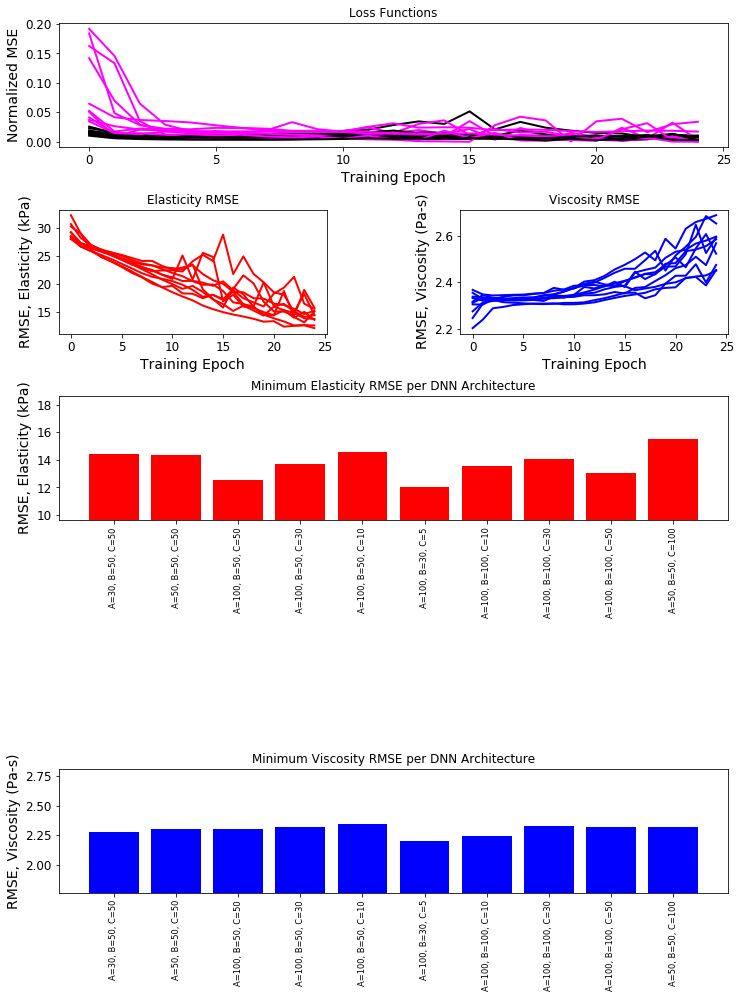

In [26]:
sizeI=np.size(Xsamp,1)
models={'A=30, B=50, C=50':  dnn4(sizeI, 30,  50, 100),
        'A=30, B=50, C=50':  dnn4(sizeI, 30,  50,  50),
        'A=50, B=50, C=50':  dnn4(sizeI, 50,  50,  50),
        'A=100, B=50, C=50': dnn4(sizeI, 100, 50,  50),
        'A=100, B=50, C=30': dnn4(sizeI, 100, 50,  30),
        'A=100, B=50, C=10': dnn4(sizeI, 100, 50,  10),
        'A=100, B=30, C=5':  dnn4(sizeI, 100, 30,   5),
        'A=100, B=100, C=10':dnn4(sizeI, 100, 100, 10),
        'A=100, B=100, C=30':dnn4(sizeI, 100, 100, 30),
        'A=100, B=100, C=50':dnn4(sizeI, 100, 100, 50),
        'A=50, B=50, C=100': dnn4(sizeI, 50,  50, 100) }

# define loss function and optimizer learning rate
criterion=nn.MSELoss()
LR=0.1

# configure training
nEpochs=25

# try out "models"
LT,LV,EM,VM=trainManyNN(models, nEpochs, criterion, LR)
assessManyNN(models, nEpochs, LT, LV, EM, VM)

## Manual Search for Hyperparameters

In [ ]:
class dnn5a(nn.Module):
    def __init__(self, input_size):
        super(dnn5a, self).__init__()
        self.fc1 = nn.Linear(input_size-2, 100) # input to hidden 1
        self.re1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 30)           # hidden 1 to hidden 2/concatenation
        self.re2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 2)             # concatenation to output
    def forward(self, x):
        in_disp = x[:-2]                        # isolate out displacement profile
        in_meta = x[-2:]                        # isolate out focal depth + axial position
        out_fc1 = self.fc1(in_disp)             # fully-connected 1 (displ. prof.) to hidden layer 1
        out_re1 = self.re1(out_fc1)
        out_fc2 = self.fc2(out_re1)             # fully-connected 2 (displ. prof.) to hidden layer 2
        out_re2 = self.re2(out_fc2)
        out_cat = torch.cat((out_fc2, in_meta)) # concatenate and fully connect to output layer
        out_all = self.fc3(out_cat)
        return out_all
    
# 5b: LeakyReLU
class dnn5b(nn.Module):
    def __init__(self, input_size):
        super(dnn5b, self).__init__()
        self.fc1 = nn.Linear(input_size-2, 100)
        self.re1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(100, 30)
        self.re2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(32, 2)
    def forward(self, x):
        in_disp = x[:-2]
        in_meta = x[-2:]
        out_fc1 = self.fc1(in_disp)
        out_re1 = self.re1(out_fc1)
        out_fc2 = self.fc2(out_re1)
        out_re2 = self.re2(out_fc2)
        out_cat = torch.cat((out_fc2, in_meta))
        out_all = self.fc3(out_cat)
        return out_all

# 5c: ELU
class dnn5c(nn.Module):
    def __init__(self, input_size):
        super(dnn5c, self).__init__()
        self.fc1 = nn.Linear(input_size-2, 100)
        self.re1 = nn.ELU()
        self.fc2 = nn.Linear(100, 30)
        self.re2 = nn.ELU()
        self.fc3 = nn.Linear(32, 2)
    def forward(self, x):
        in_disp = x[:-2]
        in_meta = x[-2:]
        out_fc1 = self.fc1(in_disp)
        out_re1 = self.re1(out_fc1)
        out_fc2 = self.fc2(out_re1)
        out_re2 = self.re2(out_fc2)
        out_cat = torch.cat((out_fc2, in_meta))
        out_all = self.fc3(out_cat)
        return out_all

# 5d: CELU
class dnn5d(nn.Module):
    def __init__(self, input_size):
        super(dnn5d, self).__init__()
        self.fc1 = nn.Linear(input_size-2, 100)
        self.re1 = nn.CELU()
        self.fc2 = nn.Linear(100, 30)
        self.re2 = nn.CELU()
        self.fc3 = nn.Linear(32, 2)
    def forward(self, x):
        in_disp = x[:-2]
        in_meta = x[-2:]
        out_fc1 = self.fc1(in_disp)
        out_re1 = self.re1(out_fc1)
        out_fc2 = self.fc2(out_re1)
        out_re2 = self.re2(out_fc2)
        out_cat = torch.cat((out_fc2, in_meta))
        out_all = self.fc3(out_cat)
        return out_all

# 5e: Softplus
class dnn5e(nn.Module):
    def __init__(self, input_size):
        super(dnn5e, self).__init__()
        self.fc1 = nn.Linear(input_size-2, 100)
        self.re1 = nn.Softplus()
        self.fc2 = nn.Linear(100, 30)
        self.re2 = nn.Softplus()
        self.fc3 = nn.Linear(32, 2)
    def forward(self, x):
        in_disp = x[:-2]
        in_meta = x[-2:]
        out_fc1 = self.fc1(in_disp)
        out_re1 = self.re1(out_fc1)
        out_fc2 = self.fc2(out_re1)
        out_re2 = self.re2(out_fc2)
        out_cat = torch.cat((out_fc2, in_meta))
        out_all = self.fc3(out_cat)
        return out_all

def tuneManyNN(modelDict, sizeIn, nEpoch=25):
    
    # initialize storage variables for estimate errors
    errorsLT=np.zeros((nEpoch, len(modelDict)))
    errorsLV=np.zeros((nEpoch, len(modelDict)))
    errorsEM=np.zeros((nEpoch, len(modelDict)))
    errorsVM=np.zeros((nEpoch, len(modelDict)))

    scaler=y_sc # handle to normalizer (sklearn)

    for cand, modelID, modelSet in zip( range(len(modelDict)),  modelDict.keys(),  modelDict.values() ):

        # start measuring computation time for assessing this network
        tCand=time.time()

        # initialize model w/ specified activation function + transfer to GPU
        if modelSet['reg']=='ReLU':
            modelNow=dnn5a(sizeIn).to(device)
        if modelSet['reg']=='LeakyReLU':
            modelNow=dnn5b(sizeIn).to(device)
        if modelSet['reg']=='ELU':
            modelNow=dnn5c(sizeIn).to(device)
        if modelSet['reg']=='CELU':
            modelNow=dnn5d(sizeIn).to(device)
        if modelSet['reg']=='Softplus':
            modelNow=dnn5e(sizeIn).to(device)
        
        # set criterion (loss function)
        if modelSet['loss']=='L1Loss':
            nn_crita=nn.L1Loss()
        if modelSet['loss']=='SmoothL1Loss':
            nn_crita=nn.SmoothL1Loss()
        if modelSet['loss']=='MSELoss':
            nn_crita=nn.MSELoss()
        if modelSet['loss']=='KLDivLoss':
            nn_crita=nn.KLDivLoss()

        # set optimization scheme
        if modelSet['optim']=='SGD':
            optimizer=torch.optim.SGD(modelNow.parameters(), lr=0.1)
        if modelSet['optim']=='Adagrad':
            optimizer=torch.optim.Adagrad(modelNow.parameters())
        if modelSet['optim']=='Adam':
            optimizer=torch.optim.Adam(modelNow.parameters())

        # set training dataset
        Xa=torch.Tensor(Xsamp).to(device).requires_grad_()
        Ya=torch.Tensor(Ysamp).to(device).requires_grad_()

        # set validation dataset
        Xb=torch.Tensor(Xtest).to(device)
        Yb=torch.Tensor(Ytest).to(device)

        for epoch in range(nEpoch):
            lossT=trainNN(Xa, Ya, modelNow, nn_crita, optimizer, verbose=0)       # train model
            _,lossV,err=validateNN(Xb, Yb, modelNow, nn_crita, scaler, verbose=0) # test model

            errorsLT[epoch,cand]=lossT # save errors
            errorsLV[epoch,cand]=lossV
            errorsEM[epoch,cand]=err[0]
            errorsVM[epoch,cand]=err[1]

        # display name of current model on console
        print(modelID, '--- model', cand+1, 'of', len(models), 'analyzed in', round(time.time()-tCand, 2), 's')
    
    # plot performance of model
    return errorsLT, errorsLV, errorsEM, errorsVM

def assessTunedNN(modelDict, nEpoch, lossTrain, lossValid, errorE, errorV):
    
    plt.figure(figsize=(12,16))
    ax1=plt.subplot(511);   ax2=plt.subplot(523);   ax3=plt.subplot(524);
    ax1.set_title('Loss Functions');  ax1.set_xlabel('Training Epoch'); ax1.set_ylabel('Cost Fun. (0 to 1)')
    ax2.set_title('Elasticity RMSE'); ax2.set_xlabel('Training Epoch'); ax2.set_ylabel('RMSE, Elasticity (kPa)')
    ax3.set_title('Viscosity RMSE');  ax3.set_xlabel('Training Epoch'); ax3.set_ylabel('RMSE, Viscosity (Pa-s)')

    for cand in range(len(modelDict)):
        errorNowLT=lossTrain[:,cand]
        errorNowLV=lossValid[:,cand]
        errorNowEM=errorE[:,cand]
        errorNowVM=errorV[:,cand]

        ax1.plot(range(nEpoch), errorNowLT, color='magenta', linewidth=2)
        ax1.plot(range(nEpoch), errorNowLV, color='black', linewidth=2)
        ax2.plot(range(nEpoch), errorNowEM, color='red', linewidth=2)
        ax3.plot(range(nEpoch), errorNowVM, color='blue', linewidth=2)
    
    plt.subplot(513)
    plt.title('Minimum Elasticity RMSE per Hyperparameter Option')
    plt.bar(range(len(modelDict)), errorE.min(axis=0), color='red')
    plt.xticks(range(len(modelDict)), modelDict.keys(), size='small', rotation='vertical')
    plt.ylabel('RMSE, Elasticity (kPa)')
    plt.ylim(np.maximum(0,  0.8*errorE.min()),
             np.minimum(30, 1.2*errorE.min(axis=0).max()) )

    plt.subplot(515)
    plt.title('Minimum Viscosity RMSE per Hyperparameter Option')
    plt.bar(range(len(modelDict)), errorV.min(axis=0), color='blue')
    plt.xticks(range(len(modelDict)), modelDict.keys(), size='small', rotation='vertical')
    plt.ylabel('RMSE, Viscosity (Pa-s)')
    plt.ylim(np.maximum(0, 0.8*errorV.min()),
             np.minimum(3, 1.2*errorV.min(axis=0).max()) )

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show

### Optimization Scheme

Stochastic Gradient Descent --- model 1 of 3 analyzed in 137.5 s
Adaptive Subgradient (AdaGrad) --- model 2 of 3 analyzed in 138.96 s
ADAM --- model 3 of 3 analyzed in 137.34 s


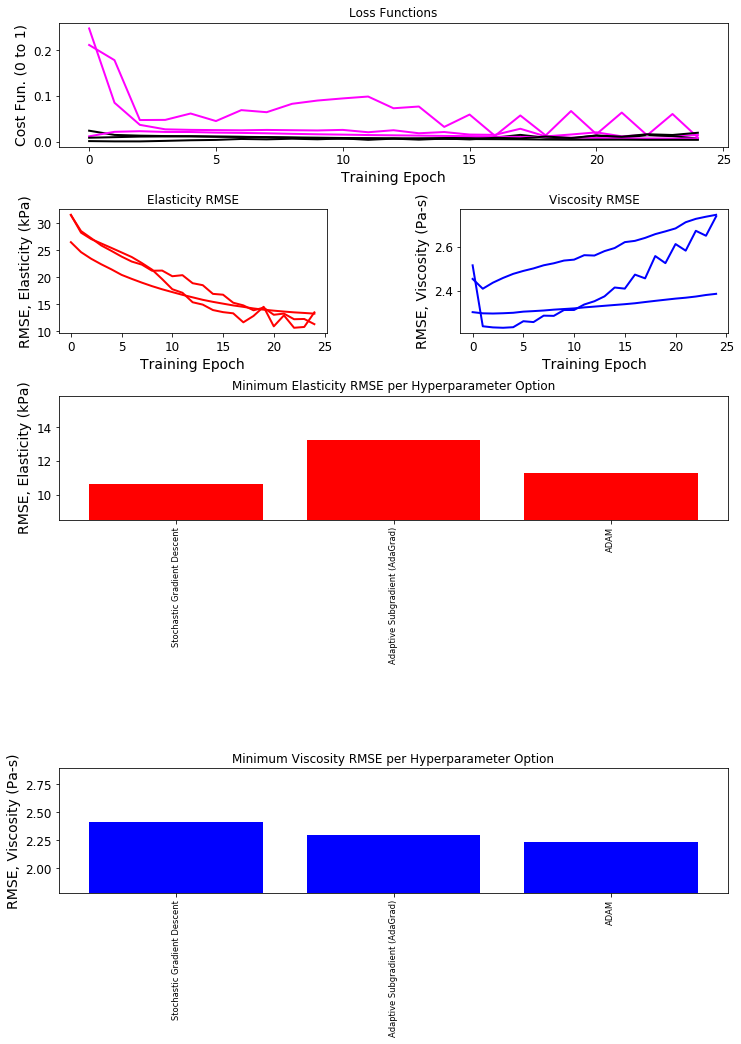

In [37]:
bestCrita='MSELoss'
bestRegul='ReLU'
models={
    'Stochastic Gradient Descent':{
        'optim':'SGD', 'loss':bestCrita, 'reg':bestRegul},
    'Adaptive Subgradient (AdaGrad)':{
        'optim':'Adagrad', 'loss':bestCrita, 'reg':bestRegul},
    'ADAM':{
        'optim':'Adam','loss':bestCrita, 'reg':bestRegul},}

LT,LV,EM,VM=tuneManyNN(models, nEpoch=25, sizeIn=np.size(Xsamp,1))
assessTunedNN(models, 25, LT, LV, EM, VM)

### Regularizer

Rectified Linear Unit (ReLU) --- model 1 of 5 analyzed in 139.7 s
Leaky ReLU --- model 2 of 5 analyzed in 134.48 s
Exponential Linear Unit --- model 3 of 5 analyzed in 133.19 s
Continuously-Differentiable Exp. Lin. Unit --- model 4 of 5 analyzed in 130.62 s
SoftPlus --- model 5 of 5 analyzed in 134.97 s


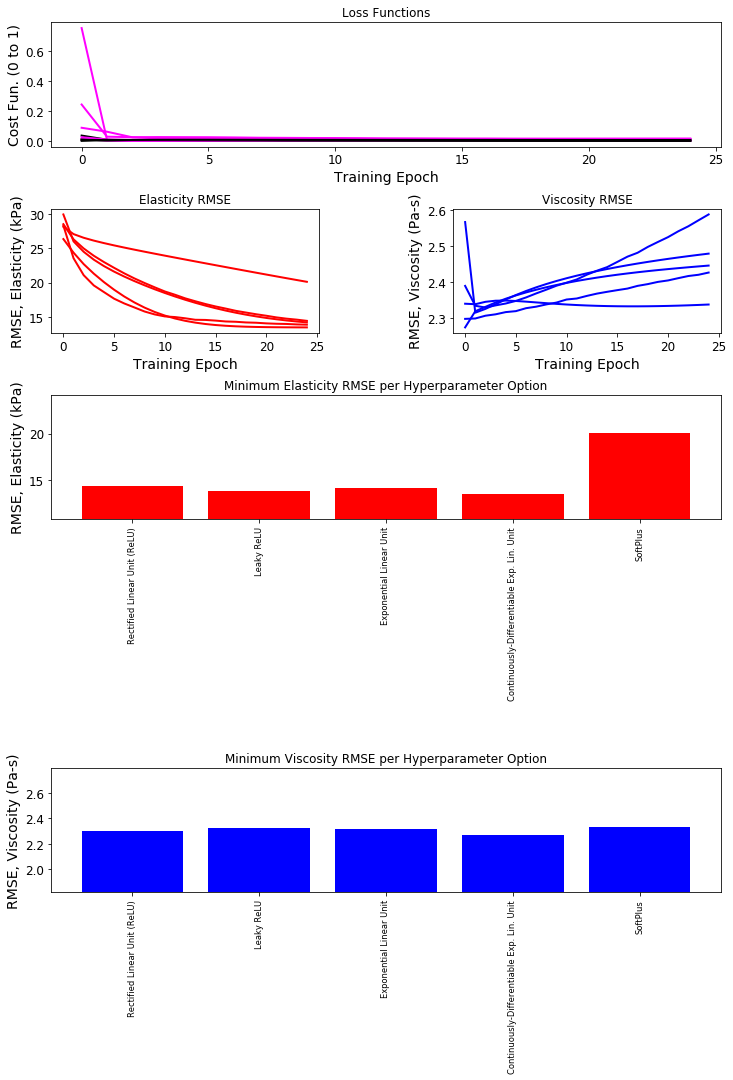

In [39]:
bestOptim='Adagrad'
bestCrita='MSELoss'
models={
    'Rectified Linear Unit (ReLU)':{
        'optim':bestOptim, 'loss':bestCrita, 'reg':'ReLU'},
    'Leaky ReLU':{
        'optim':bestOptim, 'loss':bestCrita, 'reg':'LeakyReLU'},
    'Exponential Linear Unit':{
        'optim':bestOptim, 'loss':bestCrita, 'reg':'ELU'},
    'Continuously-Differentiable Exp. Lin. Unit':{
        'optim':bestOptim, 'loss':bestCrita, 'reg':'CELU'},
    'SoftPlus':{
        'optim':bestOptim, 'loss':bestCrita, 'reg':'Softplus'}}

LT,LV,EM,VM=tuneManyNN(models, nEpoch=25, sizeIn=np.size(Xsamp,1))
assessTunedNN(models, 25, LT, LV, EM, VM)

### Cost Function

L1 Norm --- model 1 of 3 analyzed in 149.23 s
Huber (L1, smoothed) --- model 2 of 3 analyzed in 137.08 s
MSE (L2, squared) --- model 3 of 3 analyzed in 136.94 s


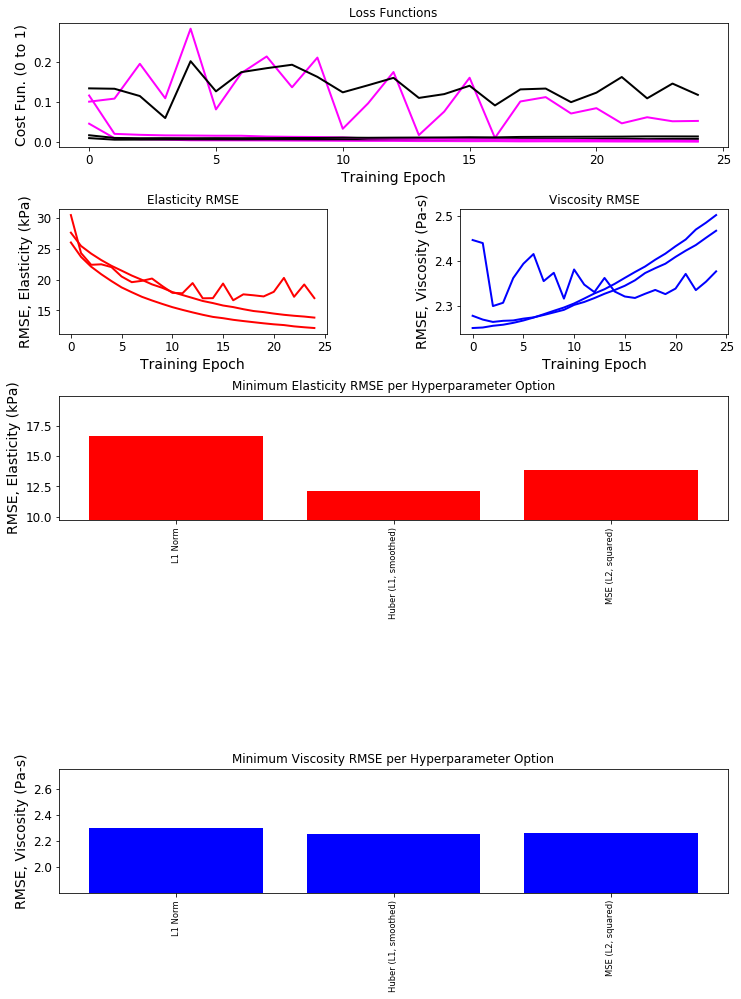

In [38]:
bestOptim='Adagrad'
bestRegul='ReLU'
models={
    'L1 Norm':{
        'optim':bestOptim, 'loss':'L1Loss', 'reg':bestRegul},
    'Huber (L1, smoothed)':{
        'optim':bestOptim, 'loss':'SmoothL1Loss','reg':bestRegul},
    'MSE (L2, squared)':{
        'optim':bestOptim, 'loss':'MSELoss', 'reg':bestRegul}
    # KLD WAS OMITTED DUE TO EXPLODING GRADIENT 'Kullback-Leibler Divergence Loss':{ 'optim':'Adagrad', 'loss':'KLDivLoss',   'reg':'ReLU'}
}

LT,LV,EM,VM=tuneManyNN(models, nEpoch=25, sizeIn=np.size(Xsamp,1))
assessTunedNN(models, 25, LT, LV, EM, VM)

# Convolutional Neural Networks

## Pytorch Dataset and Dataloader

### class ArfidataDataset

In [120]:
class ArfidataDataset(Dataset):
    """Arfidata displacement vs time dataset"""
    
    def __init__(self, metadata, root_dir, transform=None):
        """
        Args: 
            metadata (pandas.DataFrame): DataFrame containing filenames associated with elasticity, viscosity, and focal depths
            root_dir (string): Directory with all the matfiles associated with metadata filenames
            transform (callable, optional): Optional transform to be applied on a arfidata sample
        """
        self.metadata = metadata
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return self.metadata.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample_metadata = self.metadata.iloc[idx]
            
        filename = os.path.join(self.root_dir, sample_metadata['filename'])
        arfidata = loadmat(filename)['arfidata']
        fd = np.array(sample_metadata['focal_depth'])
        e = np.array(sample_metadata['elasticity'])
        v = np.array(sample_metadata['viscosity'])
        
        sample = {'arfidata': arfidata, 'focal_depth': fd, 'elasticity': e, 'viscosity': v}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
        

### Generate Dataset and Show Samples

0 (1818, 43) 15.0 100.0 0.01
1 (1818, 43) 19.0 100.0 7.01
2 (1818, 43) 24.0 78.89 1.57
3 (1818, 43) 28.0 89.44 0.79


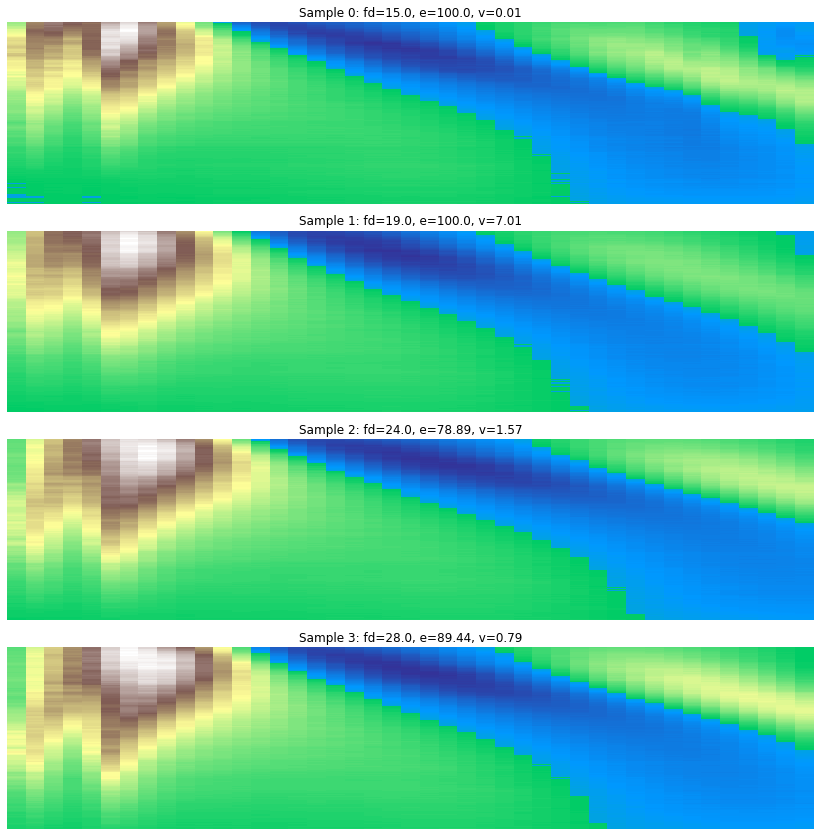

In [121]:
dataset = ArfidataDataset(metadata=metadata_median, root_dir='median_matfiles')

numsamples = 4
fig = plt.figure(figsize=(12,12))

for i in range(len(dataset)):
    sample = dataset[409*i]
    
    print(i, sample['arfidata'].shape, sample['focal_depth'], sample['elasticity'], sample['viscosity'])

    ax = plt.subplot(numsamples, 1, i+1)
    plt.tight_layout()
    ax.set_title('Sample {}: fd={:2f}, e={:2f}, v={:2f}'.format(i, sample['focal_depth'], sample['elasticity'], sample['viscosity']))
    ax.axis('off')
    show_arfidata(sample['arfidata'])
    
    if i == numsamples-1:
        plt.show()
        break
        

### Transformation Classes

In [333]:
class Normalize(object):
    """ Normalize variables and normalize arfidata (optional)
    
    Args:
        norm_arfidata (bool): State variable to determine if normalize should change arfidata
    """
    
    def __init__(self, norm_arfidata):
        self.norm_arfidata = norm_arfidata
        
    def __call__(self, sample):
        arfidata, fd, e, v = sample['arfidata'], sample['focal_depth'], sample['elasticity'], sample['viscosity']
        norm_arfidata = self.norm_arfidata
        
        # Normalize arfidata between 0 and 1
        if norm_arfidata:
            minval = torch.min(arfidata).abs()
            arfidata.add_(minval)
            maxval = torch.max(arfidata)
            arfidata.div_(maxval)
        
        
        # Scale focal depth by its maximum
        fd.div_(40)
        
        # Scale ev by their maximum (100 and 7.01)
        e.div_(100)
        v.div_(7.01)
        
        return {'arfidata': arfidata, 'focal_depth': fd, 'elasticity': e, 'viscosity': v}

class DownsampleArfidata(object):
    """Rescale the arfidata array to a given size
    
    Args:
        output_size (tuple): Desired output size
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size
        
    def __call__(self, sample):
        arfidata, fd, e, v = sample['arfidata'], sample['focal_depth'], sample['elasticity'], sample['viscosity']
        
        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        
        # Interpolate expects 4D tensor if height and width is to be changed 
        # Unsqueeze to add batch dimension to single image - squeeze back after
        arfidata = arfidata.unsqueeze(0)
        arfidata = torch.nn.functional.interpolate(arfidata, size=(new_h, new_w))
        arfidata = torch.squeeze(arfidata, dim=0)

        return {'arfidata': arfidata, 'focal_depth': fd, 'elasticity': e, 'viscosity': v}
        
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return {k: torch.from_numpy(v).type(torch.FloatTensor).unsqueeze(0) for k, v in sample.items()}

### Generate Transformed Dataset and Show Samples

0 torch.Size([1, 32, 32]) tensor([0.3750]) tensor([1.]) tensor([0.0014])
1 torch.Size([1, 32, 32]) tensor([0.4750]) tensor([1.]) tensor([1.])
2 torch.Size([1, 32, 32]) tensor([0.6000]) tensor([0.7889]) tensor([0.2240])
3 torch.Size([1, 32, 32]) tensor([0.7000]) tensor([0.8944]) tensor([0.1127])


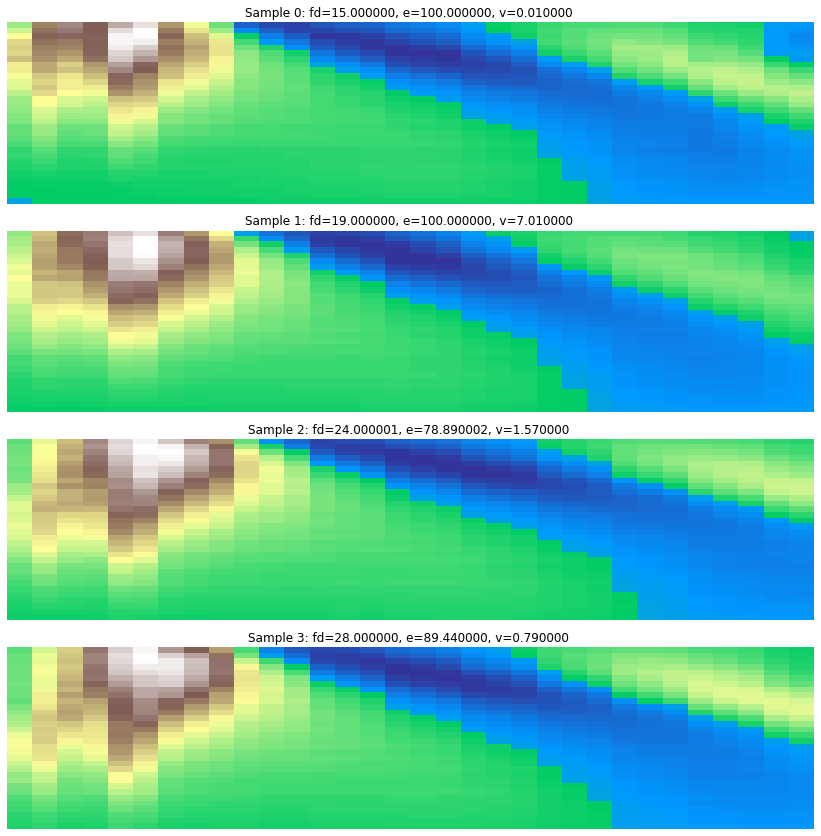

In [335]:
transform = transforms.Compose([ToTensor(), DownsampleArfidata((32,32)), Normalize(False)])
transformed_dataset = ArfidataDataset(metadata=metadata_median, root_dir='median_matfiles', transform=transform)

numsamples = 4
fig = plt.figure(figsize=(12,12))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[409*i]
    
    print(i, sample['arfidata'].size(), sample['focal_depth'], sample['elasticity'], sample['viscosity'])
    
    ax = plt.subplot(numsamples, 1, i+1)
    plt.tight_layout()
    ax.set_title('Sample {}: fd={:2f}, e={:2f}, v={:2f} '.format(i, 40*sample['focal_depth'].item(), 100*sample['elasticity'].item(), 7.01*sample['viscosity'].item()))
    ax.axis('off')
    show_arfidata(sample['arfidata'])
    
    if i == numsamples-1:
        plt.show()
        break
        

### Create Dataloader for Dataset

0 torch.Size([4, 1, 32, 32])
1 torch.Size([4, 1, 32, 32])
2 torch.Size([4, 1, 32, 32])
3 torch.Size([4, 1, 32, 32])


<Figure size 432x288 with 0 Axes>

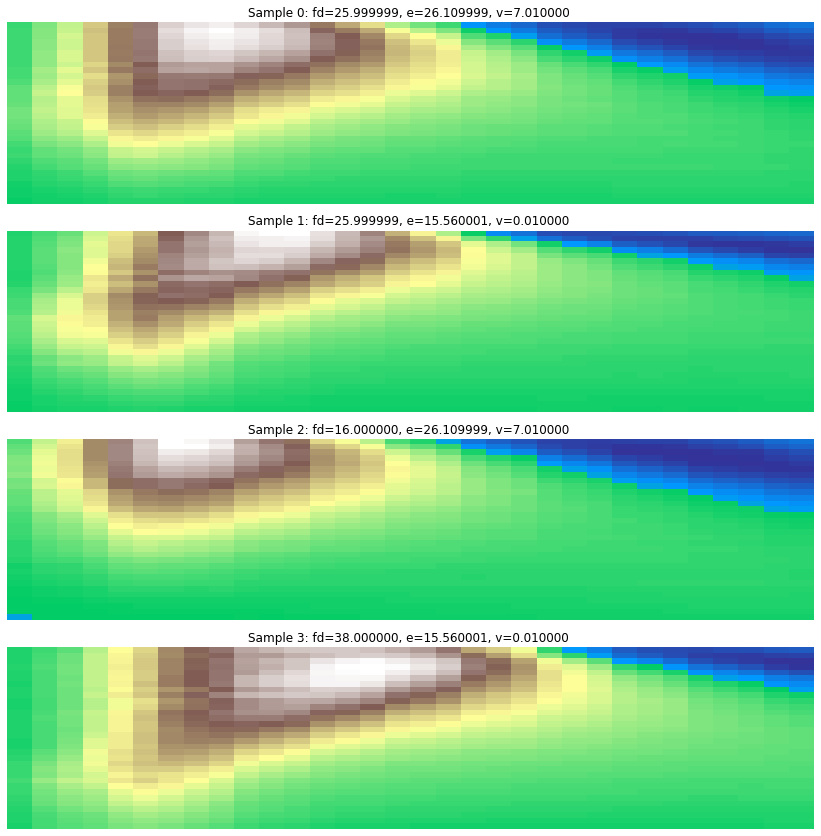

In [336]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)

def show_arfidata_batch(sample_batch):
    """ Show arfidata displacement profiles for a batch of samples """
    arfidata_batch = sample_batch['arfidata']
    batch_size = len(sample_batch)
    arfidata_size = list(arfidata_batch.size()[2:4])
    
    fig = plt.figure(figsize=(12,12))

    for i in range(batch_size):
        ax = plt.subplot(numsamples, 1, i+1)
        plt.tight_layout()
        ax.set_title('Sample {}: fd={:2f}, e={:2f}, v={:2f} '.format(i, 40*sample_batch['focal_depth'][i].item(), 100*sample_batch['elasticity'][i].item(), 7.01*sample_batch['viscosity'][i].item()))
        ax.axis('off')
        show_arfidata(sample_batch['arfidata'][i])

for i, sample_batch in enumerate(dataloader):
    print(i, sample_batch['arfidata'].size())
    
    if i == 3:
        plt.figure()
        show_arfidata_batch(sample_batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


### Train/Test Split 

In [337]:
# Get transformed dataset
transform = transforms.Compose([ToTensor(), DownsampleArfidata((32,32)), Normalize(False)])
dataset = ArfidataDataset(metadata=metadata_median, root_dir='median_matfiles', transform=transform)

# Dataloader parameters
batch_size = 10
train_split = 0.9
shuffle_dataset = True

# Train/Test split    
train_size = int(train_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(train_dataset), len(test_dataset))

# Create dataloaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_dataset, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_dataset, num_workers=0)

# Combine into a dictionary for referencing during training and validation phases
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {phase: len(dataloaders[phase].dataset) for phase in ['train', 'val']}

1985 221


## Create Model

### Calculate Layer Output Size

In [93]:
def wout_calc(win, F, P, S):
    """ This function calculates the output width (and height if symmetric) for a convolution layer 
    
    Args:
        win (int): input width
        F (int): filter size
        P (int): padding
        S (int): stride
    """
    return ((win - F + 2*P)/S) + 1

print(wout_calc(32, 3, 0, 1))

30.0


### Model Definitions

In [319]:
class MultiTargetCNN1(nn.Module):

    def __init__(self):
        super(MultiTargetCNN1, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
class MultiTargetCNN2(nn.Module):

    def __init__(self):
        super(MultiTargetCNN2, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1, 20, 3)
        self.conv2 = nn.Conv2d(20, 10, 3)
        self.fc1 = nn.Linear(10 * 6 * 6, 100)  # 6*6 from image dimension
        self.fc2 = nn.Linear(100, 60)
        self.fc3 = nn.Linear(60, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

print(MultiTargetCNN1())
print(MultiTargetCNN2())

MultiTargetCNN1(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
MultiTargetCNN2(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=360, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=2, bias=True)
)


## Training Helper Functions

In [321]:
def train_model(model, criterion, optimizer, num_epochs, verbose=False):
    # Function
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100000.0
    
    train_losses = []
    val_losses = []
    losses = {phase: [] for phase in ['train', 'val']}

    for epoch in range(num_epochs):
        if verbose: print('Epoch [{}/{}]'.format(epoch + 1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            # Iterate over data
            for i, batch in enumerate(dataloaders[phase]):
                arfidata = batch['arfidata'].to(device)
                ev = torch.cat((batch['elasticity'], batch['viscosity']), 1).to(device)
                # Zero the parameter gradients between batches
                optimizer.zero_grad()

                # Forward
                # Track history only while training
                with torch.set_grad_enabled(phase == 'train'):
                    predictions = model(arfidata)
                    loss = criterion(predictions, ev)

                    # Backward + optimize only while training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Statistics - add batch loss to running loss for epoch
                    running_loss += loss.item()*arfidata.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            if verbose: print('{} Loss: {}'.format(phase, epoch_loss))
                
            # Save epoch losses to lists
            losses[phase].append(epoch_loss)
            
            # Deep copy model if its the best so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        if verbose: print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    return model, losses, time_elapsed, best_loss

def model_validation(model):
    model.eval()
    ev_all = []
    predictions_all = []

    with torch.no_grad():
        for i, batch in enumerate(dataloaders['val']):
            arfidata = batch['arfidata'].to(device)
            ev = torch.cat((batch['elasticity'], batch['viscosity']), 1).to(device)
            predictions = model(arfidata)

            ev_all.append(ev)
            predictions_all.append(predictions)

    val = torch.cat(ev_all, dim=0)
    pred = torch.cat(predictions_all, dim=0)

    val_true = inorm(val)
    pred_true = inorm(pred)
    
    rmse_true = rmse(pred_true, val_true)
    aberr_true = aberr(pred_true, val_true)

    descriptive_stats(aberr_true)
    print('RMSE:    {:6f}    {:6f}'.format(rmse_true[0], rmse_true[1]))
    
def plot_losses(losses, best_loss):    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(losses['train'], color='tab:blue')
    ax.plot(losses['val'], color='tab:orange')
    ax.set_title('Training and Validation Loss Curves')
    ax.set_xlabel('Number of Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Training', 'Validation'], loc='upper right')
    
def inorm(x):
    return x.mul(torch.Tensor([100, 7.01]).to(device))

def rmse(predictions, validation):
    return ((pred_true - val_true) ** 2).mean(dim=0).sqrt()

def aberr(predictions, validation):
    return (pred_true - val_true).abs()

def descriptive_stats(err):
    print(pd.DataFrame(err.cpu().numpy(), columns=['e', 'v']).describe())

## Train Models

Epoch [1/250]
train Loss: 0.13624425052245256
val Loss: 0.06843636097276912

Epoch [2/250]
train Loss: 0.061753286869835194
val Loss: 0.05755596168389822

Epoch [3/250]
train Loss: 0.054196842502736924
val Loss: 0.05353638216246307

Epoch [4/250]
train Loss: 0.049769938489426895
val Loss: 0.04848273182751366

Epoch [5/250]
train Loss: 0.0458800711995108
val Loss: 0.04578050409709167

Epoch [6/250]
train Loss: 0.04247343849850542
val Loss: 0.04386782880484788

Epoch [7/250]
train Loss: 0.04004594355221059
val Loss: 0.04073550648211893

Epoch [8/250]
train Loss: 0.03524011322379263
val Loss: 0.043857475944975924

Epoch [9/250]
train Loss: 0.03370583595787773
val Loss: 0.031877774441808594

Epoch [10/250]
train Loss: 0.027775039361503624
val Loss: 0.025024376813811144

Epoch [11/250]
train Loss: 0.022068099407314953
val Loss: 0.019857351476436153

Epoch [12/250]
train Loss: 0.017368162683063477
val Loss: 0.015205533210002729

Epoch [13/250]
train Loss: 0.013548182438524153
val Loss: 0.015

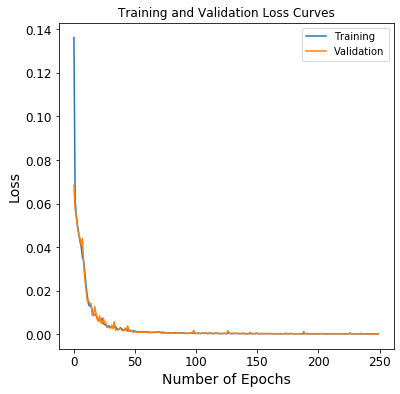

In [342]:
num_epochs = 250

model1 = MultiTargetCNN1()
model1.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

model1, losses1, time_elapsed1, best_loss1 = train_model(model1, criterion, optimizer, num_epochs, verbose=True)
model_validation(model1)
plot_losses(losses1, best_loss1)

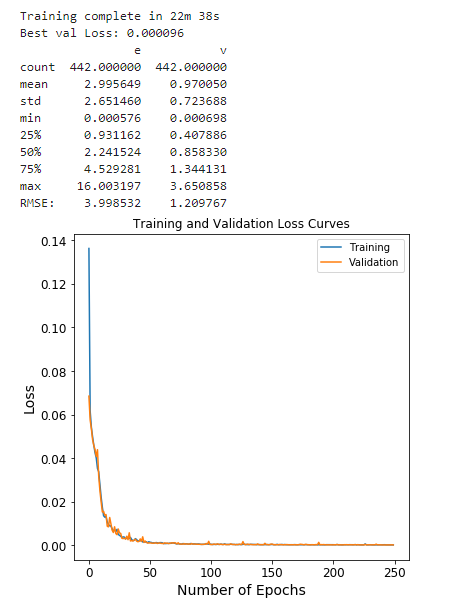

Epoch [1/250]
train Loss: 0.11190870535613907
val Loss: 0.06772889459834379

Epoch [2/250]
train Loss: 0.06481901320725003
val Loss: 0.05750351717771448

Epoch [3/250]
train Loss: 0.05840225094549301
val Loss: 0.05346404498957131

Epoch [4/250]
train Loss: 0.053599309138672176
val Loss: 0.05052837526333009

Epoch [5/250]
train Loss: 0.049679460928256924
val Loss: 0.04782858926684878

Epoch [6/250]
train Loss: 0.0457018801581199
val Loss: 0.0526990319066997

Epoch [7/250]
train Loss: 0.04157124093313812
val Loss: 0.03918368695093091

Epoch [8/250]
train Loss: 0.037165948731698074
val Loss: 0.0372517076215593

Epoch [9/250]
train Loss: 0.03421700768576236
val Loss: 0.03503203354944471

Epoch [10/250]
train Loss: 0.029315452325985925
val Loss: 0.02602151131133098

Epoch [11/250]
train Loss: 0.02374529500048542
val Loss: 0.021403786705225303

Epoch [12/250]
train Loss: 0.020738988403953443
val Loss: 0.019849706110354866

Epoch [13/250]
train Loss: 0.016544431713069567
val Loss: 0.014191683

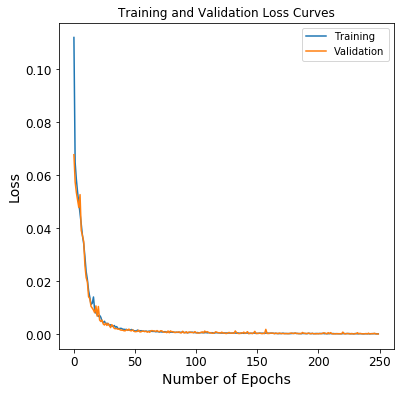

In [345]:
num_epochs = 250

model2 = MultiTargetCNN2()
model2.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

model2, losses2, time_elapsed2, best_loss2 = train_model(model2, criterion, optimizer, num_epochs, verbose=True)
model_validation(model2)
plot_losses(losses2, best_loss2)

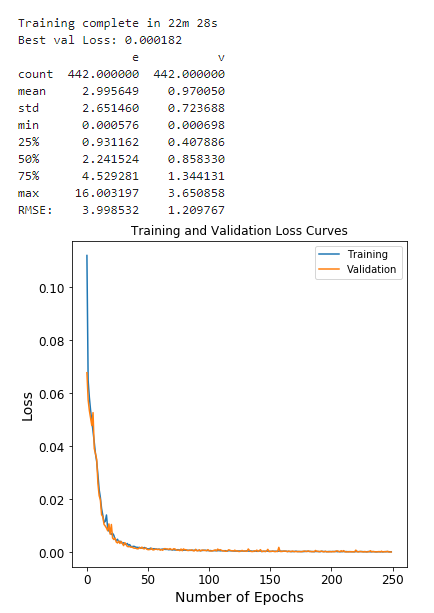

# Future Directions

## Descriptive Stats in Addition to RMSE
Running descriptive stats on sklearn models with decent rmse errors showed high maximum errors

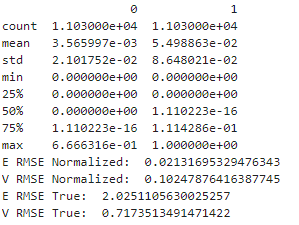

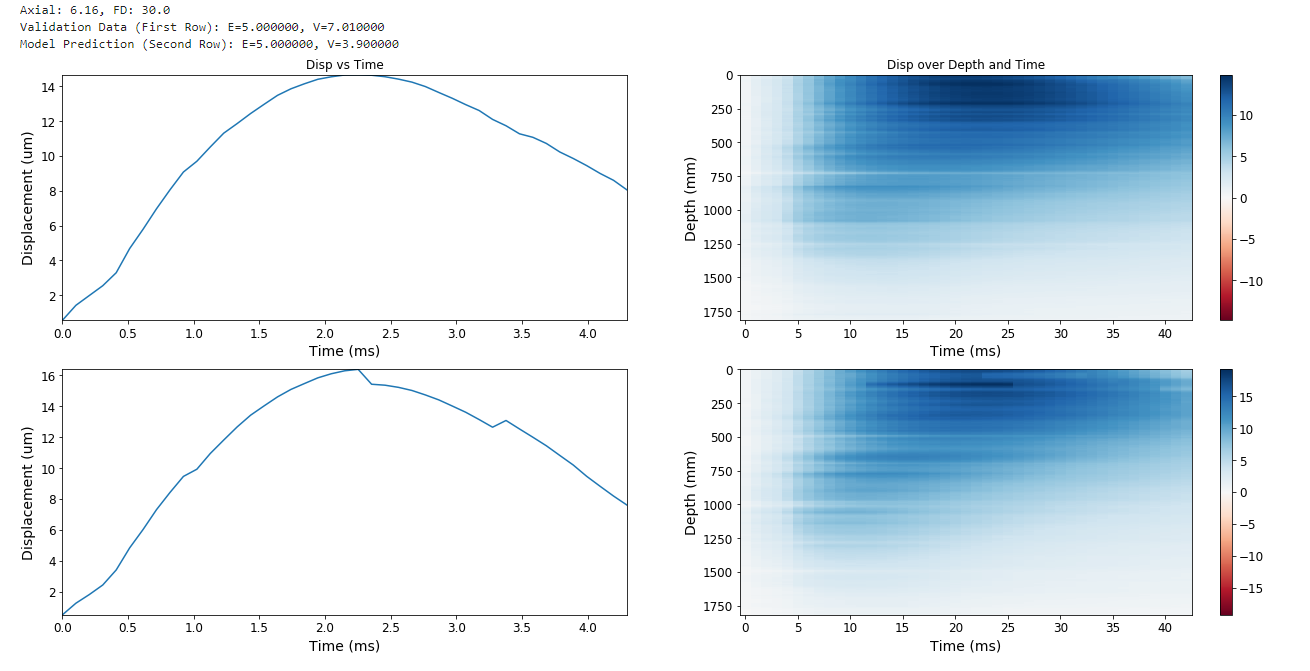

## Additional Considerations for DNN